# Disease Prediction Binary Classification Problem

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

In [3]:
# Read train data

df = pd.read_csv('C:\\Users\\hites\\Downloads\\Disease Prediction Training.csv')

In [4]:
# Read test data

df_test = pd.read_csv('C:\\Users\\hites\\Downloads\\Disease Prediction Testing.csv')

In [5]:
df.head()

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
0,59,female,167,88.0,130,68,normal,normal,0,0,1,0
1,64,female,150,71.0,140,100,normal,normal,0,0,0,1
2,41,female,166,83.0,100,70,normal,normal,0,1,1,0
3,50,male,172,110.0,130,80,normal,normal,1,0,1,0
4,39,female,162,61.0,110,80,high,high,0,0,1,0


In [6]:
df_test.head()

,ID,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise
0,0,44,female,160,59.0,100,80,high,normal,0,0,1
1,1,41,female,169,74.0,120,70,normal,normal,0,0,1
2,2,63,male,168,84.0,120,80,normal,high,0,0,1
3,3,55,female,158,108.0,160,100,normal,normal,0,0,0
4,4,55,female,167,67.0,120,80,normal,normal,0,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  49000 non-null  int64  
 1   Gender               49000 non-null  object 
 2   Height               49000 non-null  int64  
 3   Weight               49000 non-null  float64
 4   High Blood Pressure  49000 non-null  int64  
 5   Low Blood Pressure   49000 non-null  int64  
 6   Cholesterol          49000 non-null  object 
 7   Glucose              49000 non-null  object 
 8   Smoke                49000 non-null  int64  
 9   Alcohol              49000 non-null  int64  
 10  Exercise             49000 non-null  int64  
 11  Disease              49000 non-null  int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 4.5+ MB


In [8]:
# Checking the null values in the train data

df.isnull().sum()

Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
Disease                0
dtype: int64

**We can see that there are no missing values in the train data. We need to look for data quality issues.**

In [9]:
# Checking the null values in the test data

df_test.isnull().sum()

ID                     0
Age                    0
Gender                 0
Height                 0
Weight                 0
High Blood Pressure    0
Low Blood Pressure     0
Cholesterol            0
Glucose                0
Smoke                  0
Alcohol                0
Exercise               0
dtype: int64

In [10]:
# Unique number of values in each column of train dataset

df.nunique()

Age                     28
Gender                   2
Height                 101
Weight                 248
High Blood Pressure    143
Low Blood Pressure     143
Cholesterol              3
Glucose                  3
Smoke                    2
Alcohol                  2
Exercise                 2
Disease                  2
dtype: int64

# Data Cleaning

**1. Checking for Highly Co-related Columns** <br>
**2. Checking for the duplicate values** <br>
**3. Outliers Detection and Handling** <br>
**4. Data Normalization when needed in case of distance based algorithms** <br>


**1. Checking for Highly Co-related Columns**

Text(0.5, 1.0, 'Heatmap Correlation between the Input features')

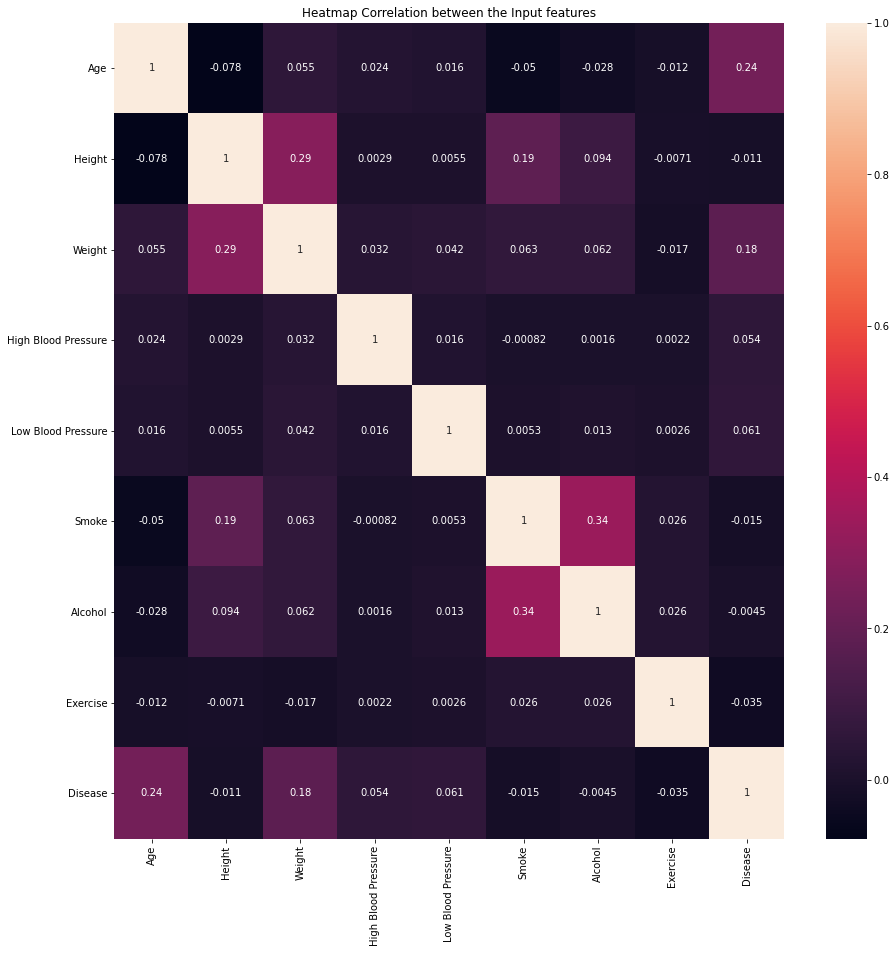

In [11]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True) # Correlation between the Columns to find the highly correlated columns to remove multi-collinearity
plt.title('Heatmap Correlation between the Input features')

**From the correlation between the input features, we can see that the target variable is most related to Age and after that with Weight. Disease risk would be higher for people whose age is more. As the person becomes older, the chances of getting the disease increase as is the case for weight. With increase in weight, disease chances increase. Smoke and Alcohol are related to each other with highest positive correaltion of 0.34.**

**Checking for Imbalance in the dataset (Target Variable)**

In [12]:
df.Disease.value_counts(normalize=True)

0    0.500041
1    0.499959
Name: Disease, dtype: float64

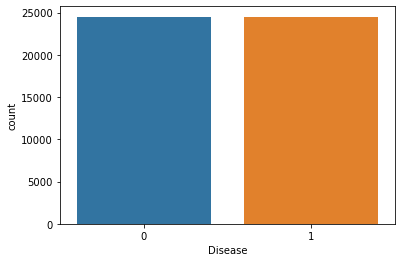

In [13]:
sns.countplot(x='Disease',data=df)

**Target Variable which we are predicting is balanced**

**2. Checking for the duplicate values**

In [14]:
df.drop_duplicates(keep='first',inplace=True)

In [15]:
print('Number of duplicate records are',49000 - df.shape[0])

Number of duplicate records are 1752


In [16]:
df.shape

(47248, 12)

**3. Outlier Detection and Handling**

In [17]:
df.describe()

,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease
count,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000,47248.000000
mean,52.863126,164.352735,74.442470,129.013461,97.557209,0.091411,0.056235,0.799378,0.509567
std,6.791208,8.314608,14.469526,150.324461,204.020137,0.288196,0.230378,0.400470,0.499914
min,29.000000,55.000000,10.000000,-150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,1.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,207.000000,200.000000,14020.000000,11000.000000,1.000000,1.000000,1.000000,1.000000


### Although the data seems clean without missing values, there are outliers and data quality issues which can be seen clearly.

**1. Height and Weight Column Values seem to have issue. Minimum Height of 55 and minimum weight of 15kg is very rare. Also, the maximum values for these 2 columns seem to have issue which needs to be resolved as there might be outliers.** <br>
**2. High Blood Pressure and Low Blood Pressure Minimum values of -150 and 0 along with Maximum values of 14000 and 11000 are clearly outliers and cannot be possible. The range of High and Low Blood Pressure was looked and these lower and upper bounds would be clipped to remove the extreme ouliers.**  <br>


In [18]:
# Function to clip the upper and lower bounds of data in a column with unusual data values

def clip_max_min(df,col,max_val,min_val):
    df[col][df[col] > max_val] = max_val
    df[col][df[col] < min_val] = min_val

### Height Column Values Correction

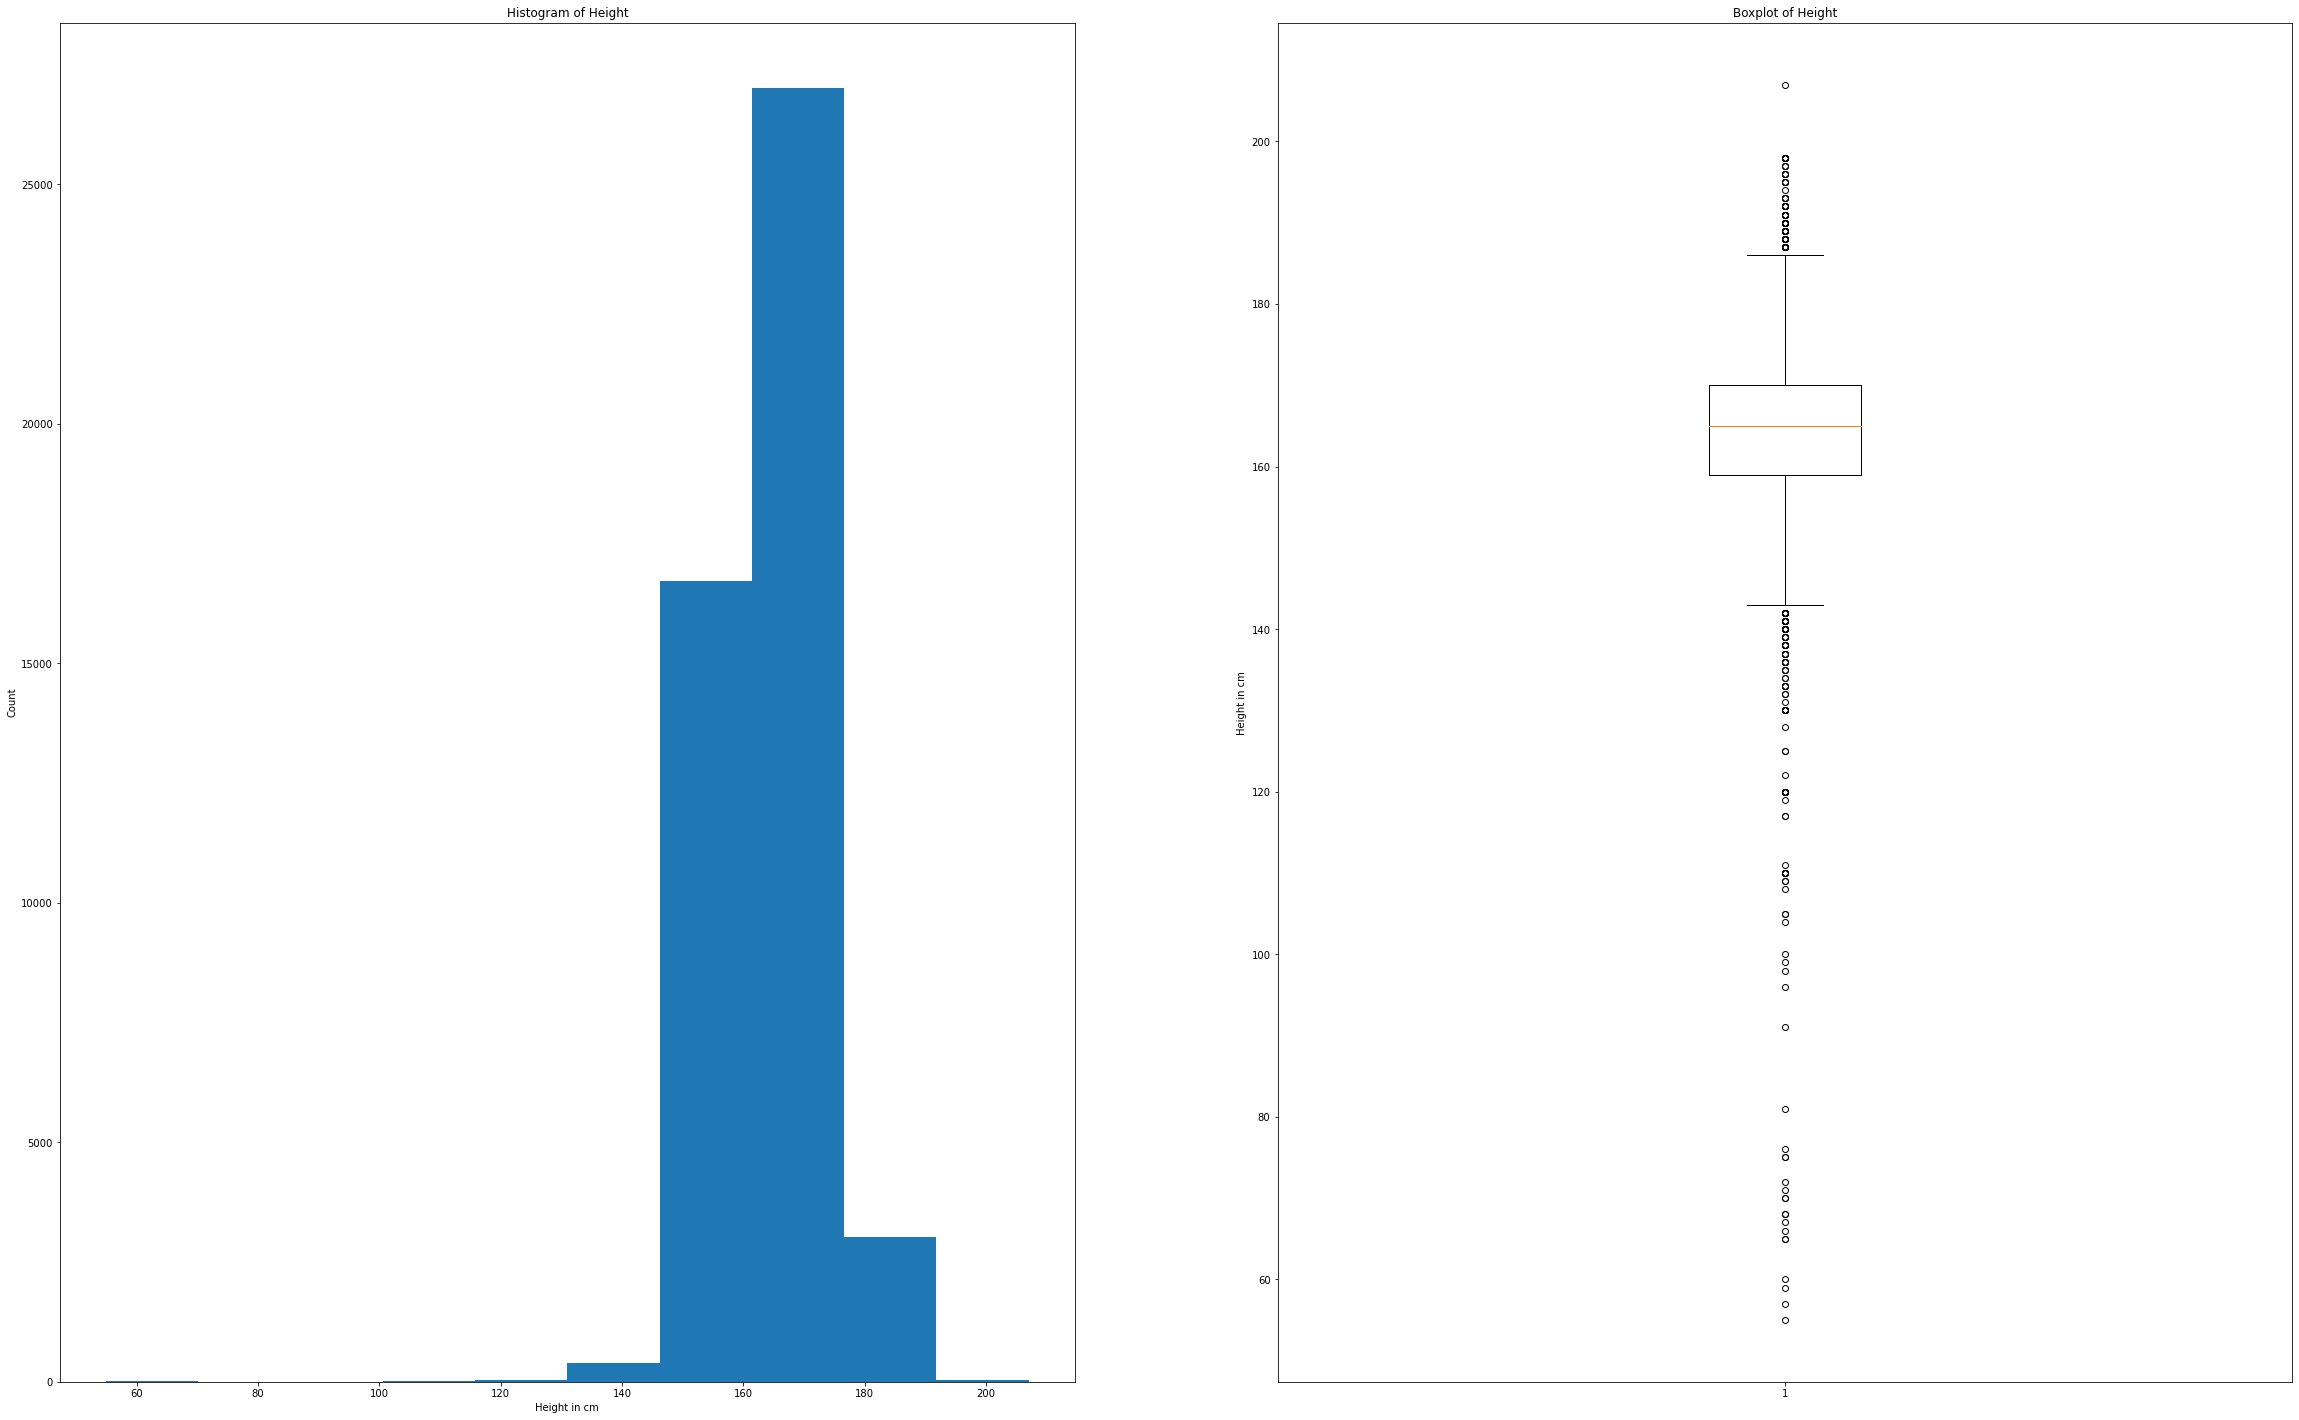

In [19]:

plt.figure(figsize=(40,25))
plt.subplot(1,2,1)
plt.hist(df.Height,histtype='bar') 
plt.xlabel('Height in cm')
plt.ylabel('Count')
plt.title('Histogram of Height')

plt.subplot(1,2,2)
plt.boxplot(df.Height)
plt.ylabel('Height in cm')
plt.title('Boxplot of Height')

plt.show()

In [20]:
clip_max_min(df,'Height',200,125)

<ipython-input-18-09666814766e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] > max_val] = max_val
<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


In [21]:
clip_max_min(df_test,'Height',200,125)

<ipython-input-18-09666814766e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] > max_val] = max_val
<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


**Clipping the Minimum Height value at 125 cm and maximum height at 200 cm. For adults of age between 30 to 65, height of people would range in between these 2 values.**

### Weight Column Values Correction

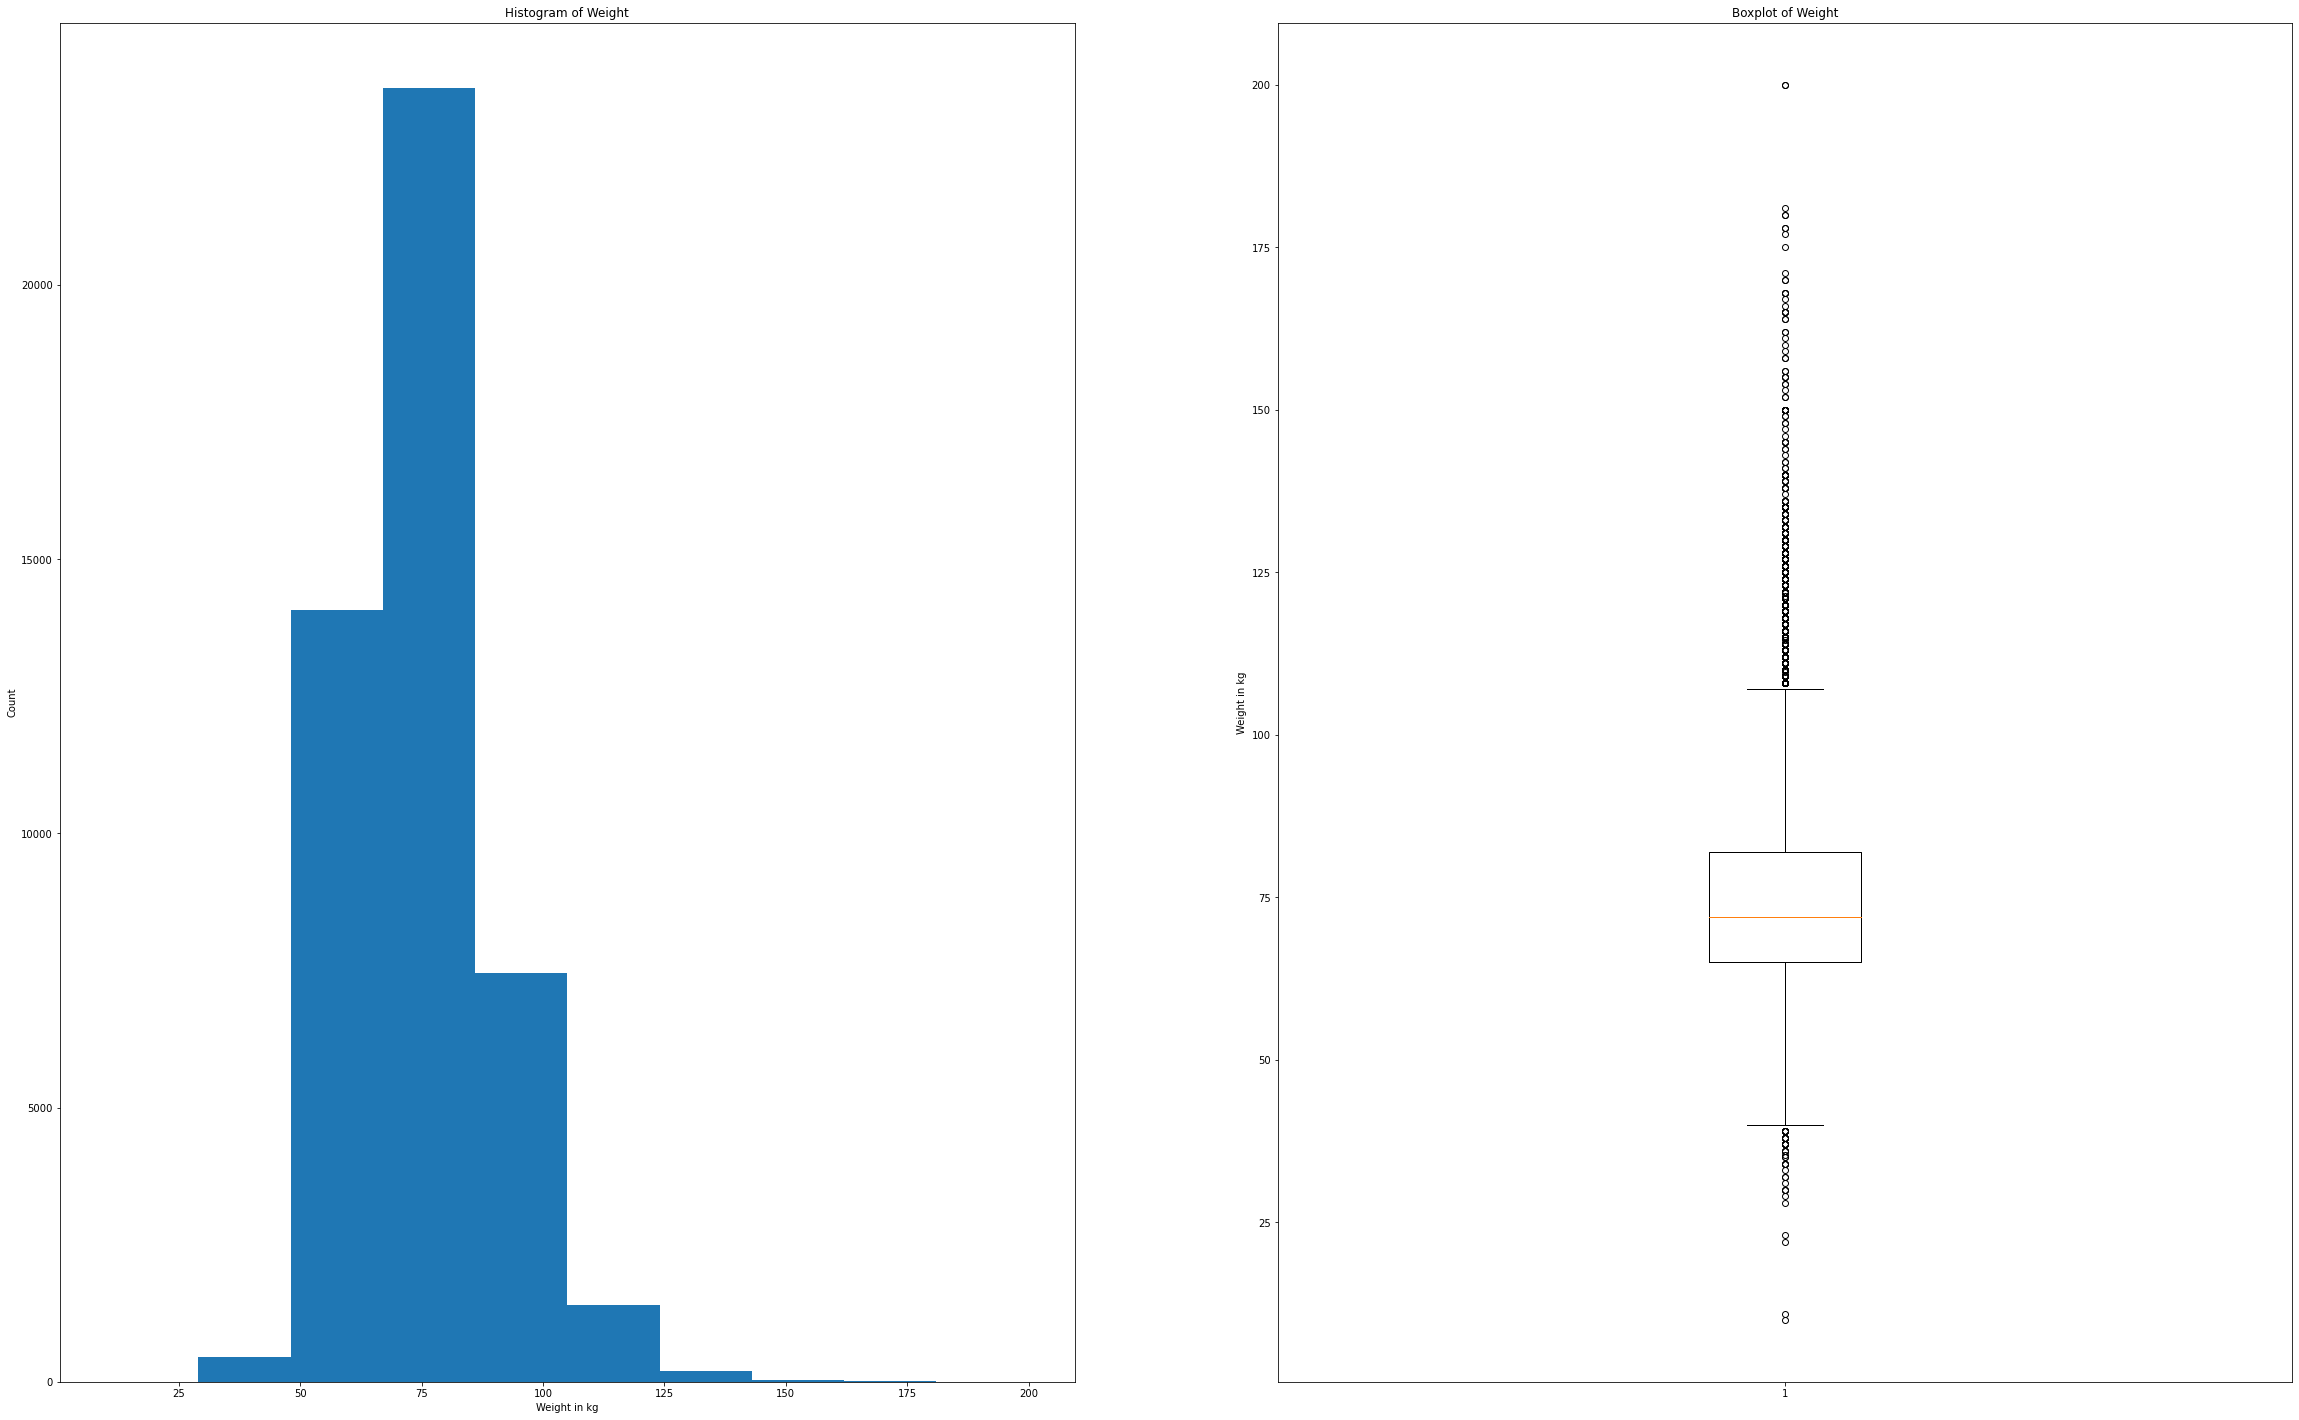

In [22]:
plt.figure(figsize=(40,25))
plt.subplot(1,2,1)
plt.hist(df.Weight,histtype='bar') 
plt.xlabel('Weight in kg')
plt.ylabel('Count')
plt.title('Histogram of Weight')

plt.subplot(1,2,2)
plt.boxplot(df.Weight)
plt.ylabel('Weight in kg')
plt.title('Boxplot of Weight')

plt.show()

In [23]:
clip_max_min(df,'Weight',180,40)

<ipython-input-18-09666814766e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] > max_val] = max_val
<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


In [24]:
clip_max_min(df_test,'Weight',180,40)

<ipython-input-18-09666814766e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] > max_val] = max_val
<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


**Clipping the Minimum Weight value at 40 kg and maximum weight at 180 kg. For adults of age between 30 to 65, weight of people would range in between these 2 values and would rarely go beyonf this range.**

### Creating New Feature BMI (Body Mass Index)

**BMI is calculated based on weight and height and it tells whether the person is obese or healthy or overweight. If we know that person is healthy, the chances of getting the disease reduces whereas if the person is overweight or obese, his/her chances of getting the disease increase to be higher probability. So, BMI is very helpful and our models like Random Forest and GBM would tell us if we are right based on the feature importances indicating if BMI is contributing significantly or not in model's disease prediction.**

In [25]:
df['BMI'] = df["Weight"]/ (df["Height"]/100)**2

In [26]:
df_test['BMI'] = df_test["Weight"]/ (df_test["Height"]/100)**2

### BMI Index Values Correction

In [27]:
bmi_filter = ((df['BMI'] < 10) | (df['BMI'] > 60))

In [28]:
df = df[~bmi_filter]

**Filtering the BMI Index values below 10 and above 60 as these are the cases of extreme outliers based on the BMI value range in real world. Having BMI beyond this means extreme underweight or overweight which can lead to outliers being present in the data and it happens only in a few cases. So, it would better to remove these rows.**

In [29]:
df.shape

(47229, 13)

### High Blood Pressure Values Correction

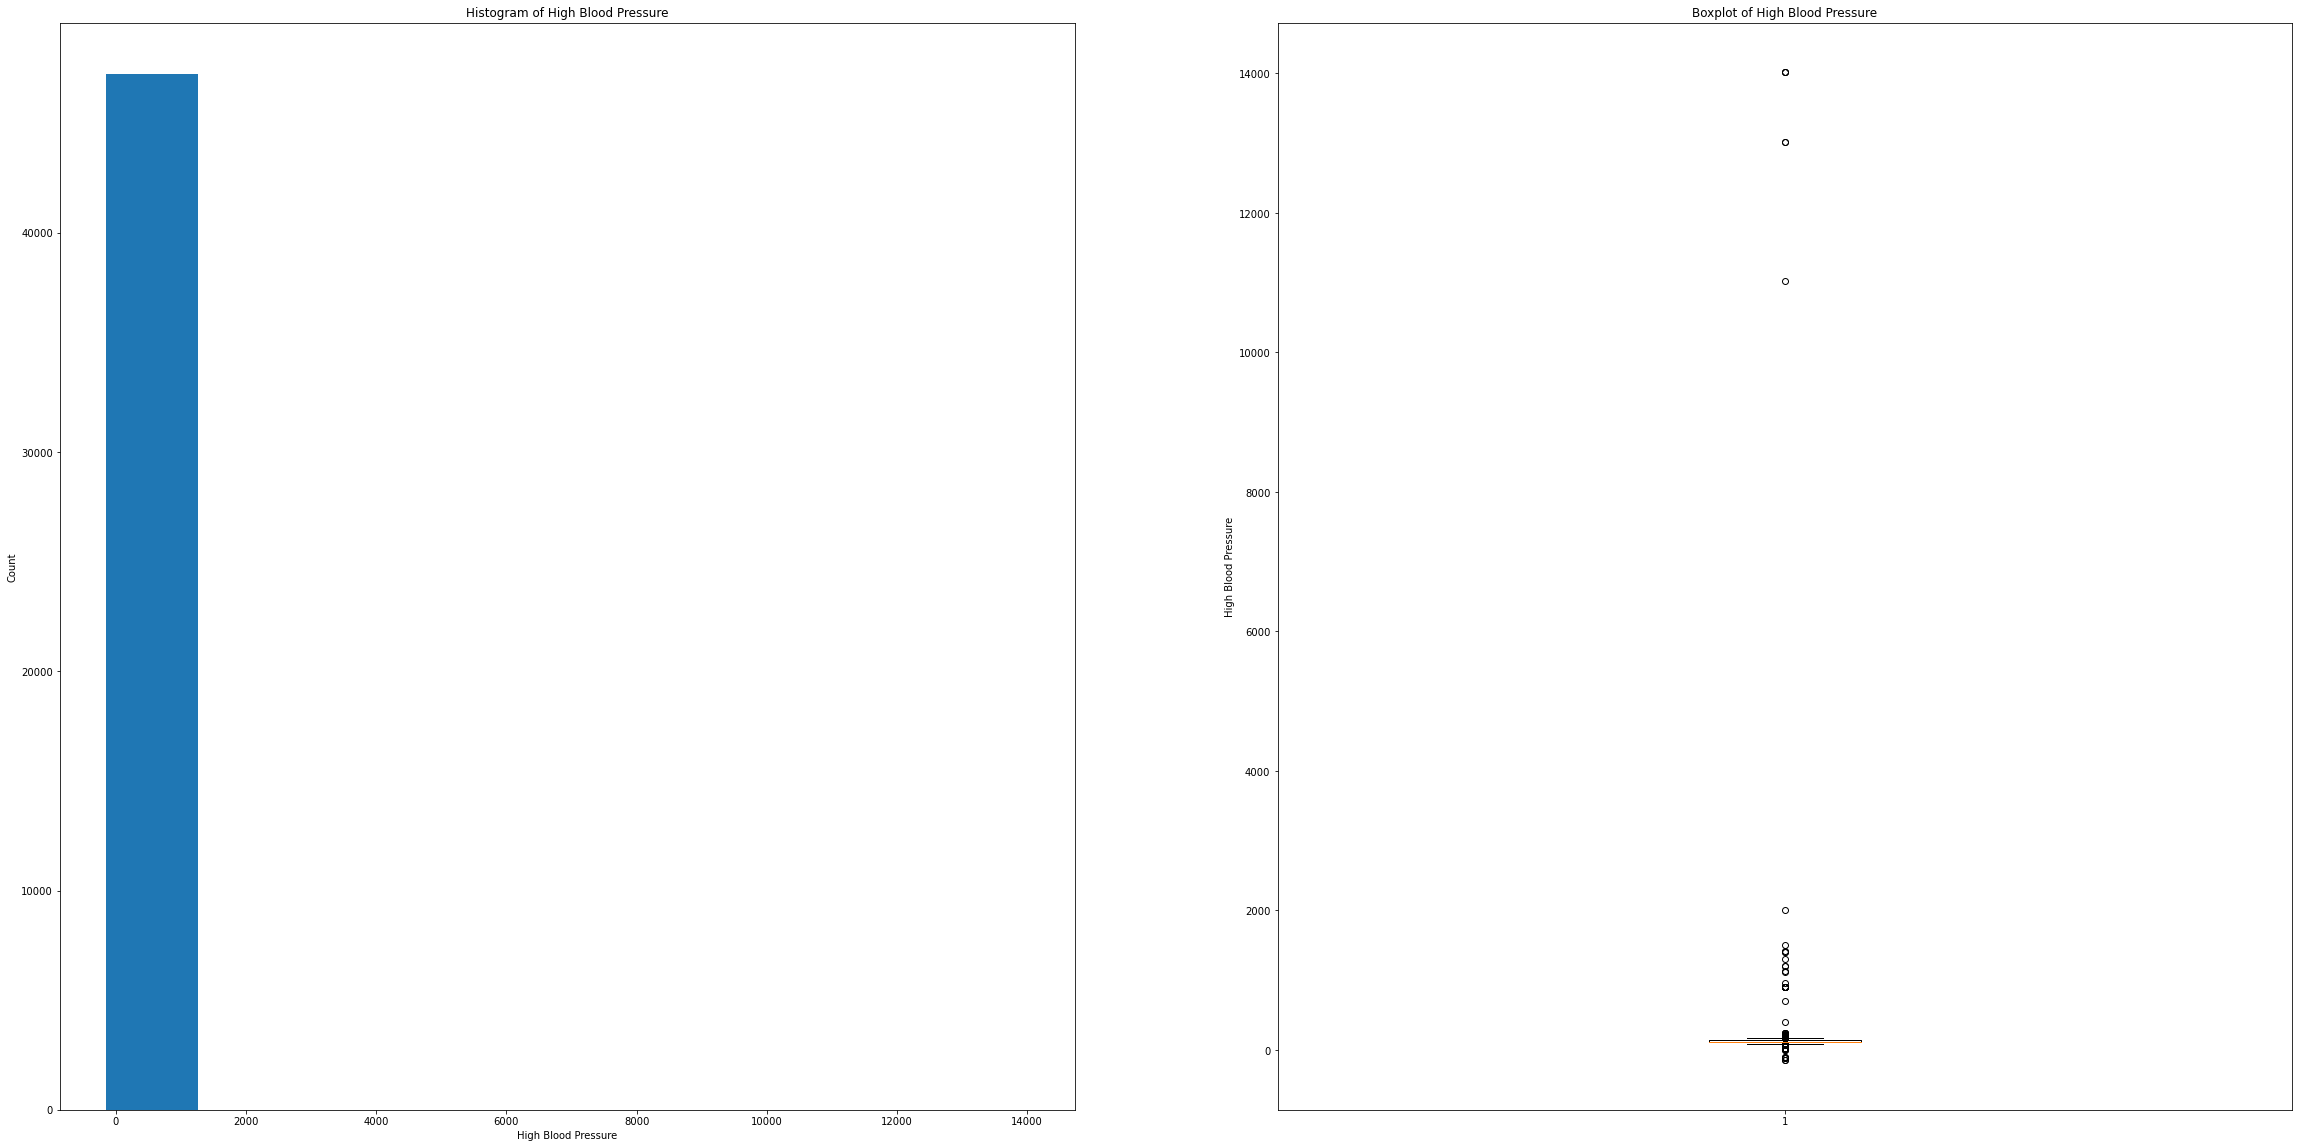

In [30]:
plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
plt.hist(df['High Blood Pressure'],histtype='bar') 
plt.xlabel('High Blood Pressure')
plt.ylabel('Count')
plt.title('Histogram of High Blood Pressure')

plt.subplot(1,2,2)
plt.boxplot(df['High Blood Pressure'])
plt.ylabel('High Blood Pressure')
plt.title('Boxplot of High Blood Pressure')

plt.show()

In [31]:
clip_max_min(df,'High Blood Pressure',200,60)

<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


In [32]:
clip_max_min(df_test,'High Blood Pressure',200,60)

<ipython-input-18-09666814766e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] > max_val] = max_val
<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


**Clipping the values of High Blood Pressure to range between 200 maximum and 60 minimum based on the values for their range as accepted by the medical professionals. The High Blood Pressure which is known as Systolic Blood Pressure in Medical Terms has the range of 90 to 120 for normal blood pressure. Anything below that or higher than that would increase the risk of disease.** 

### Low Blood Pressure Values Correction 

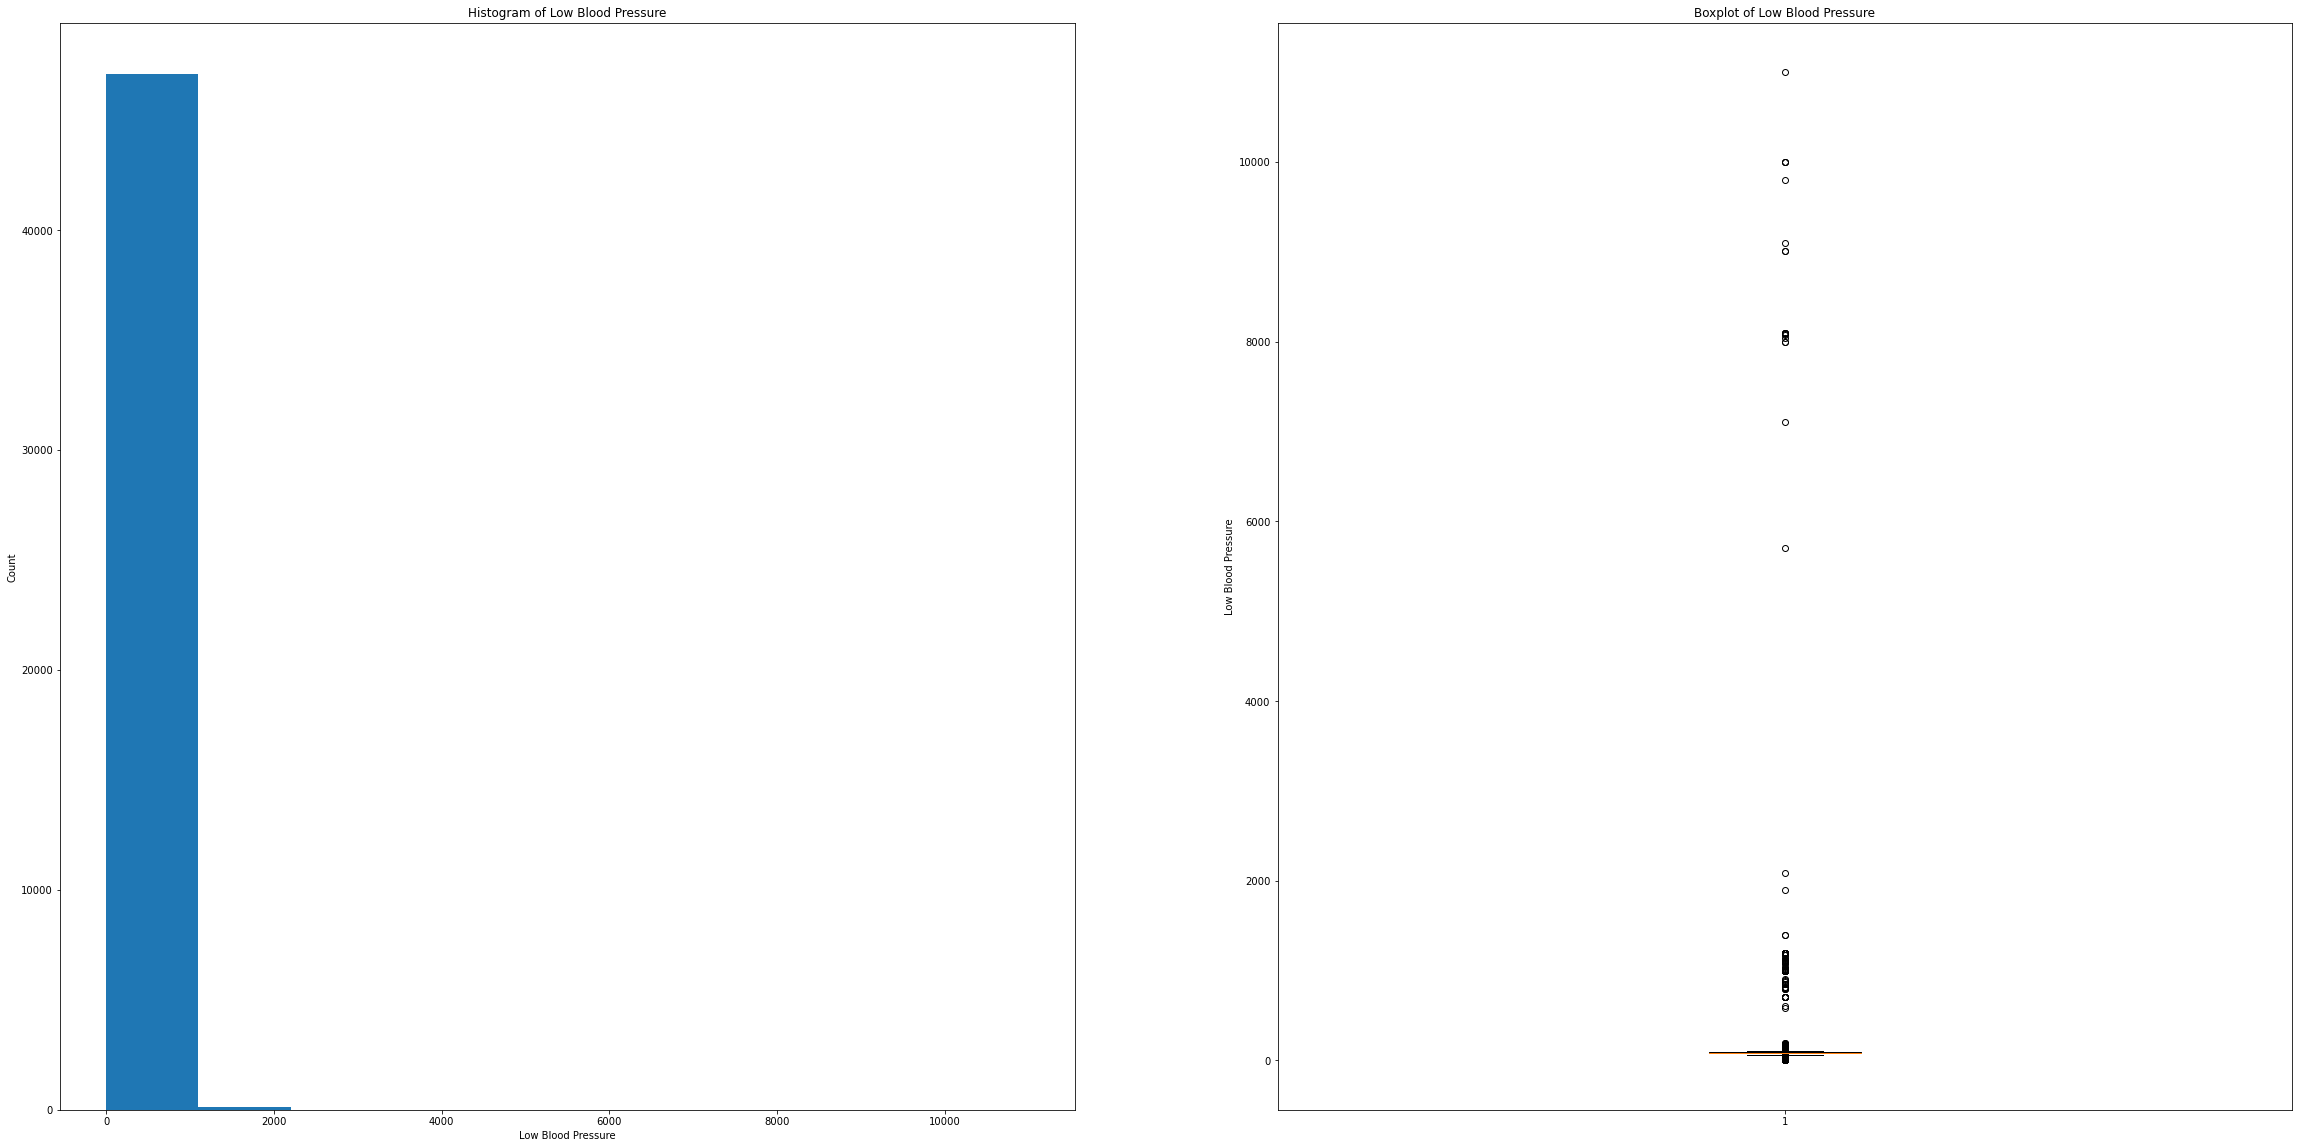

In [33]:
plt.figure(figsize=(40,20))
plt.subplot(1,2,1)
plt.hist(df['Low Blood Pressure'],histtype='bar') 
plt.xlabel('Low Blood Pressure')
plt.ylabel('Count')
plt.title('Histogram of Low Blood Pressure')

plt.subplot(1,2,2)
plt.boxplot(df['Low Blood Pressure'])
plt.ylabel('Low Blood Pressure')
plt.title('Boxplot of Low Blood Pressure')

plt.show()

In [34]:
clip_max_min(df,'Low Blood Pressure',130,50)

<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


In [35]:
clip_max_min(df_test,'Low Blood Pressure',130,50)

<ipython-input-18-09666814766e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] > max_val] = max_val
<ipython-input-18-09666814766e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] < min_val] = min_val


**Clipping the values of Low Blood Pressure to range between 130 maximum and 50 minimum based on the values for their range as accepted by the medical professionals. The Low Blood Pressure which is known as Diastolic Blood Pressure in Medical Terms has the range of 60 to 80 for normal blood pressure. Anything below that or higher than that would increase the risk of disease.**

### Checking if the High Blood Pressure Values are greater than Lower Pressure Values

In [36]:
df[df['High Blood Pressure'] < df['Low Blood Pressure']]

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease,BMI
409,53,male,158,61.0,60,80,too high,too high,0,0,1,0,24.435187
441,40,male,188,96.0,80,130,normal,normal,0,1,1,0,27.161612
671,48,male,173,78.0,90,130,normal,normal,0,1,1,1,26.061679
905,48,female,125,45.0,60,80,normal,normal,0,0,1,0,28.800000
1018,42,female,152,60.0,60,80,normal,normal,0,0,1,0,25.969529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47917,52,male,166,95.0,60,90,normal,normal,0,0,0,1,34.475250
47977,56,female,167,72.0,60,80,normal,normal,0,0,1,1,25.816630
47985,61,female,162,72.0,80,130,too high,too high,0,0,1,1,27.434842
48165,58,female,155,69.0,60,90,normal,too high,0,0,1,1,28.720083


**There are 228 rows where High Blood Pressure is lower than Low Blood Pressure. This is not possible according to the Medical Science. We cannot have High Blood Pressure lower than Low Blood Pressure. So, this may be data quality issue which could be solved only by reversing the values for High and Low Blood Pressure where High Blood Pressure is lower than Low Blood Pressure.**

In [37]:
# Function to reverse the values in High and Low Blood Pressure if High Blood Pressure < Low Blood Pressure

def pressure_reverse(df,col1,col2):
    cond = df[col1] < df[col2]
    df.loc[cond, [col1, col2]] = df.loc[cond, [col2, col1]].values

In [38]:
pressure_reverse(df,'High Blood Pressure','Low Blood Pressure')

In [39]:
df[df['High Blood Pressure'] < df['Low Blood Pressure']]

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease,BMI


In [40]:
pressure_reverse(df_test,'High Blood Pressure','Low Blood Pressure')

In [41]:
df_test.shape

(21000, 13)

In [42]:
df.describe()

,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease,BMI
count,47229.000000,47229.000000,47229.000000,47229.000000,47229.000000,47229.000000,47229.000000,47229.000000,47229.000000,47229.000000
mean,52.861970,164.391751,74.413314,127.230303,81.964513,0.091406,0.056237,0.799339,0.509496,27.578421
std,6.791741,8.057371,14.344451,17.388207,11.150947,0.288188,0.230381,0.400499,0.499915,5.266484
min,29.000000,125.000000,40.000000,60.000000,50.000000,0.000000,0.000000,0.000000,0.000000,12.624669
25%,48.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,23.875433
50%,53.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,1.000000,26.562500
75%,58.000000,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000,30.427198
max,64.000000,200.000000,180.000000,200.000000,130.000000,1.000000,1.000000,1.000000,1.000000,59.523810


## All the data quality issues are resolved including the outliers, data entry or collection issues to make our data as clean and accurate to help models make accurate prediction.

# EDA

### Bivariate Analysis

Text(0.5, 1.0, 'Age plot for disease')

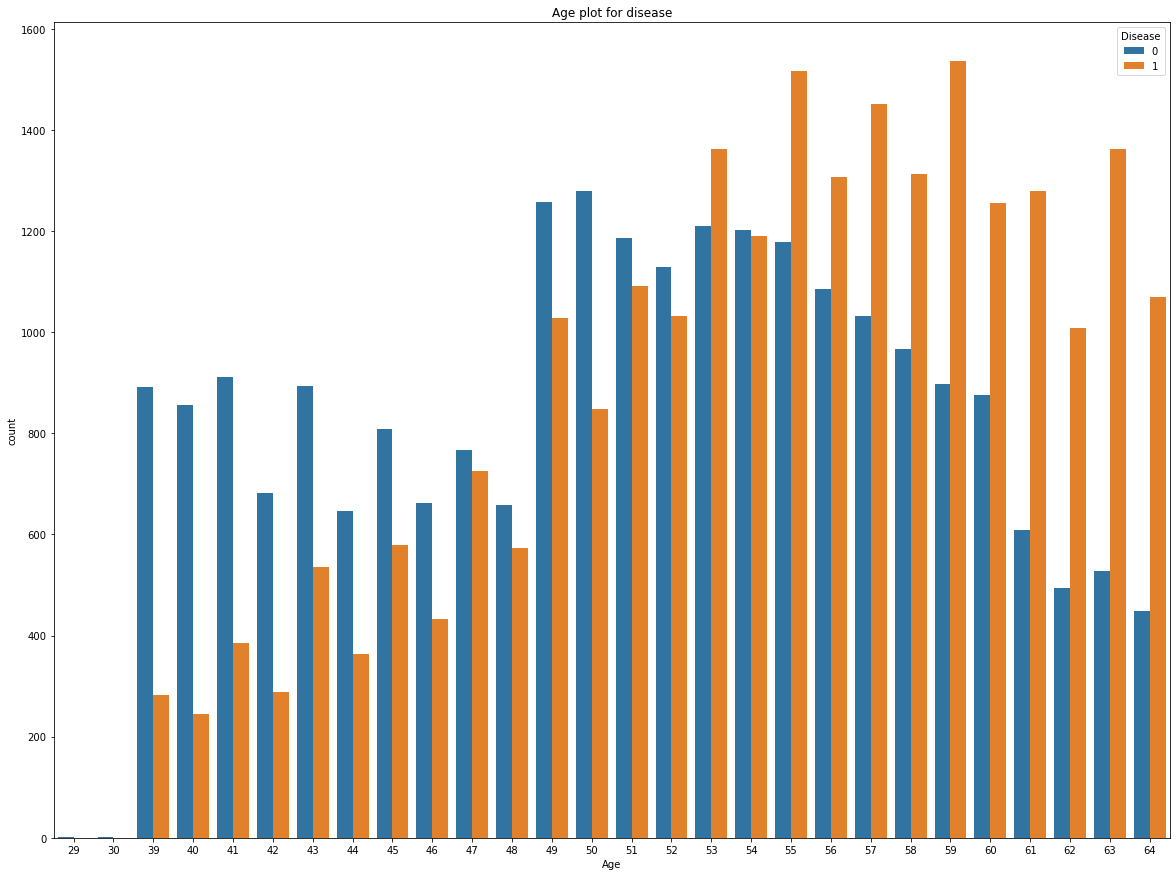

In [43]:
plt.figure(figsize=(20,15))
sns.countplot(hue = df['Disease'], x = df['Age'])
plt.title('Age plot for disease')

**It can be seen that the risk of disease gets higher with the increasing age. For the people in their 50's the risk is higher than people who are in their 40's and the Seniors who are 60 or above have the highest chances of getting the disease.**

Text(0.5, 1.0, 'BMI Index plot for disease')

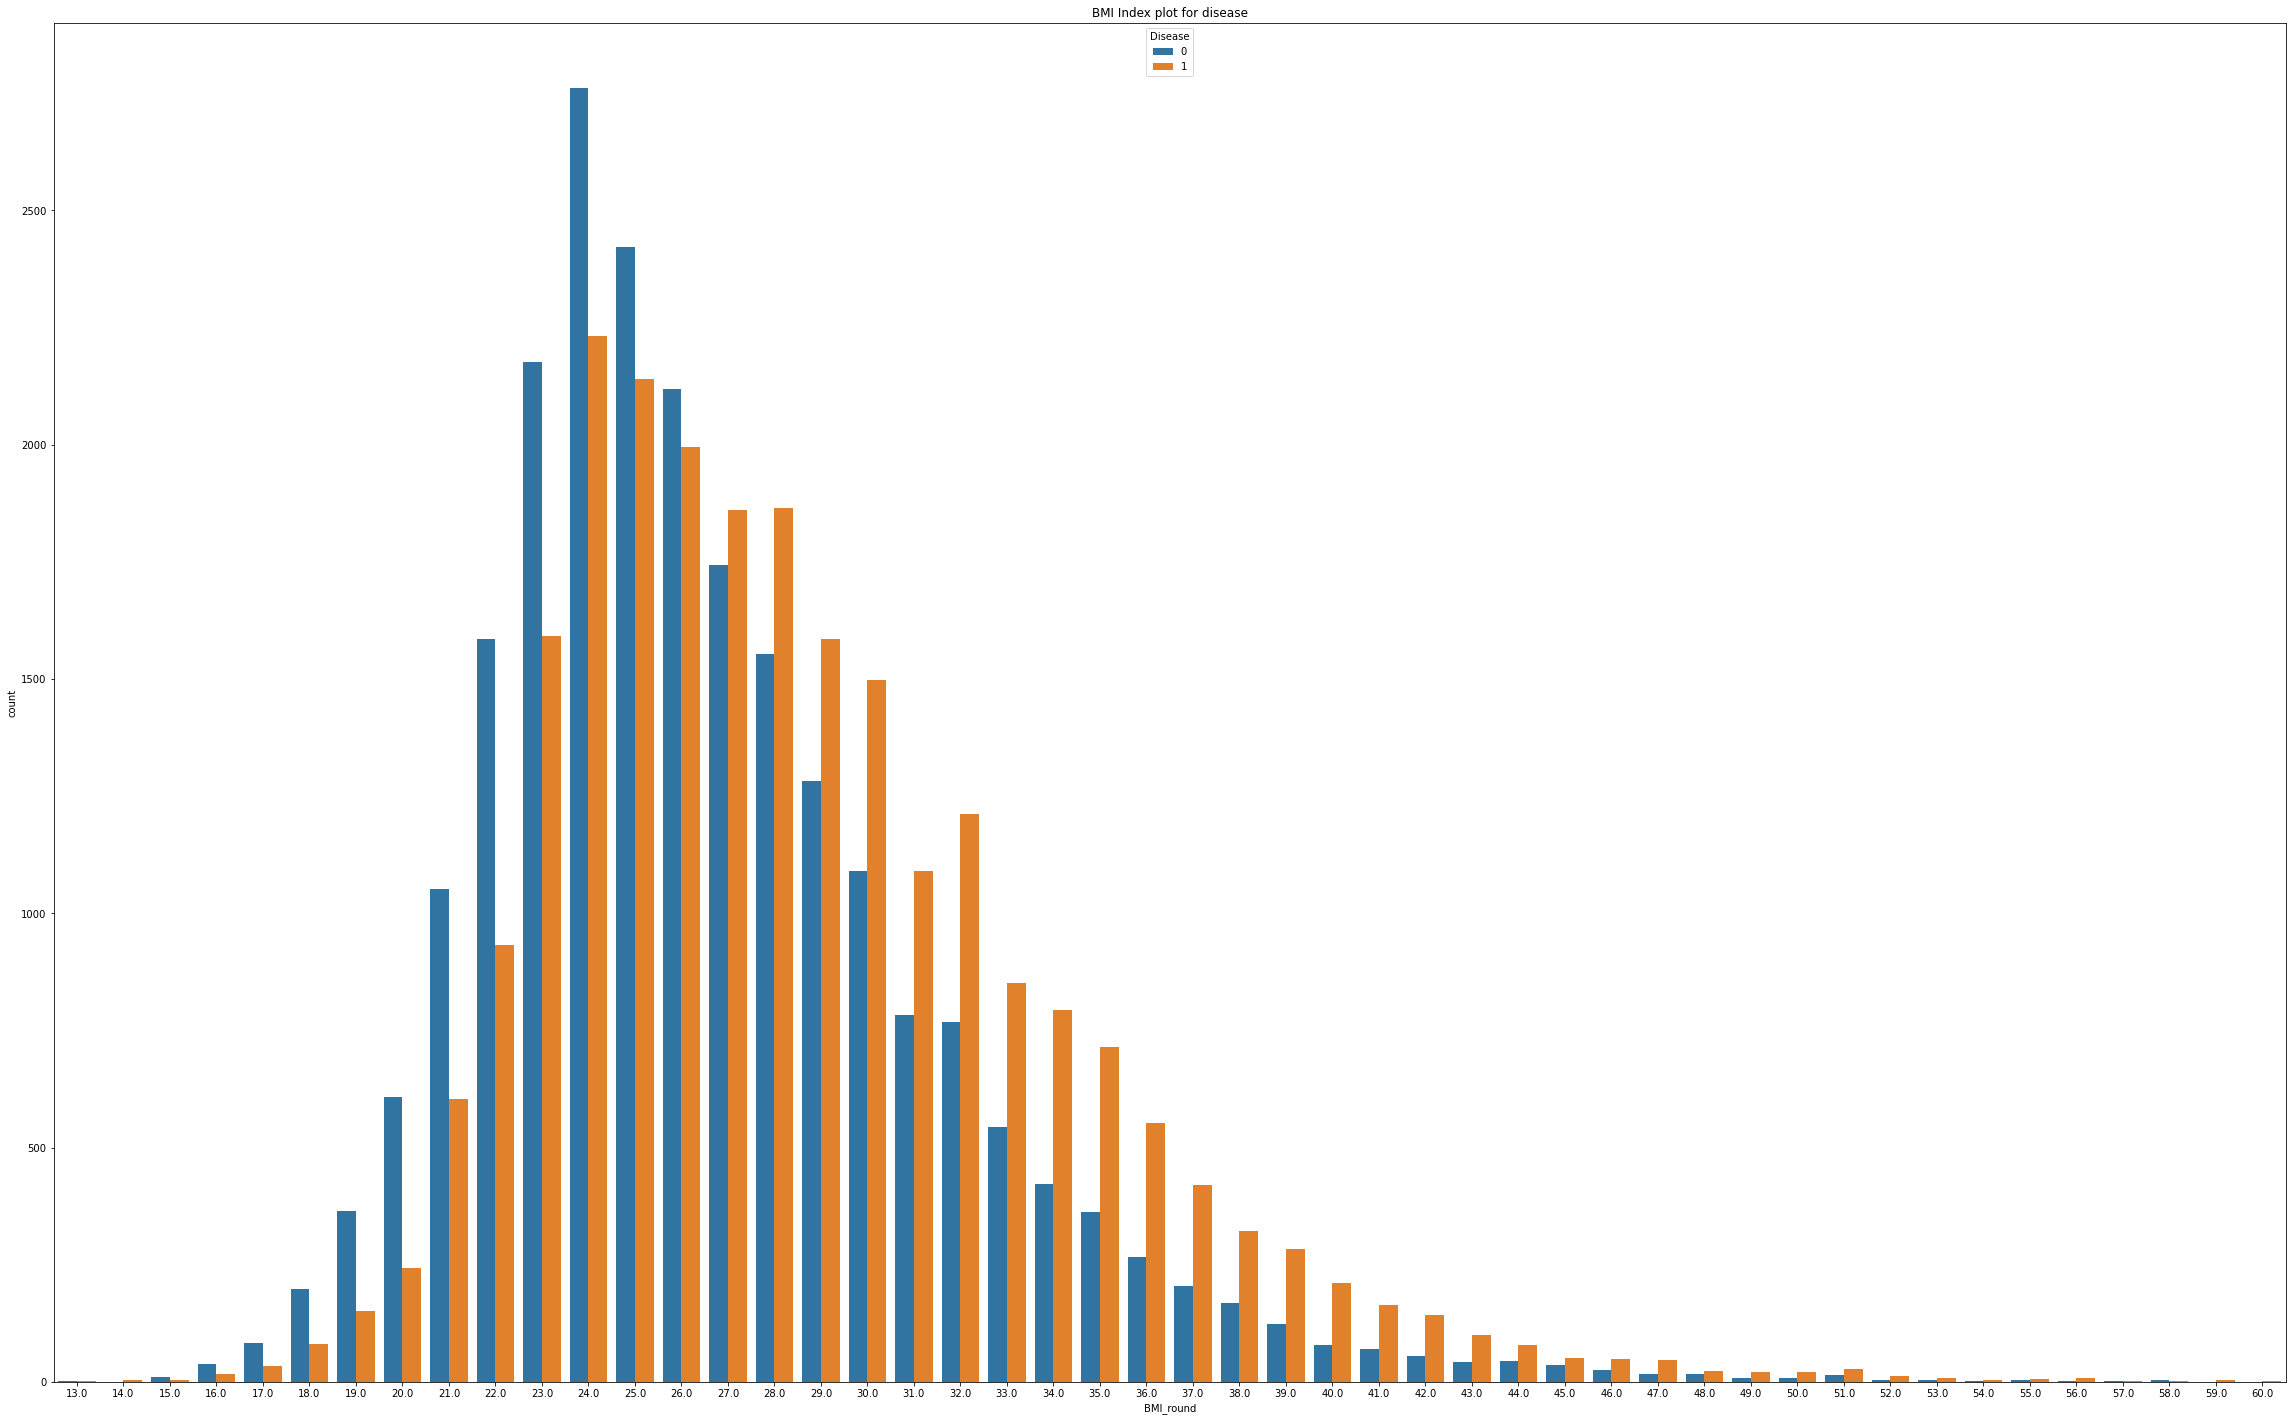

In [44]:
df1 = df.copy()
plt.figure(figsize=(40,25))
df1['BMI_round'] = df1.BMI.round()
sns.countplot(x='BMI_round',hue='Disease',data=df1)
plt.title('BMI Index plot for disease')

**BMI Index values greater than 25 indicate Obesity and increase the risk of getting the disease. If the people are very obese they would have issues with their metabolism and also have high risk than people who are healthy to get disease.**

Text(0.5, 1.0, 'Low Blood Pressure plot for Disease')

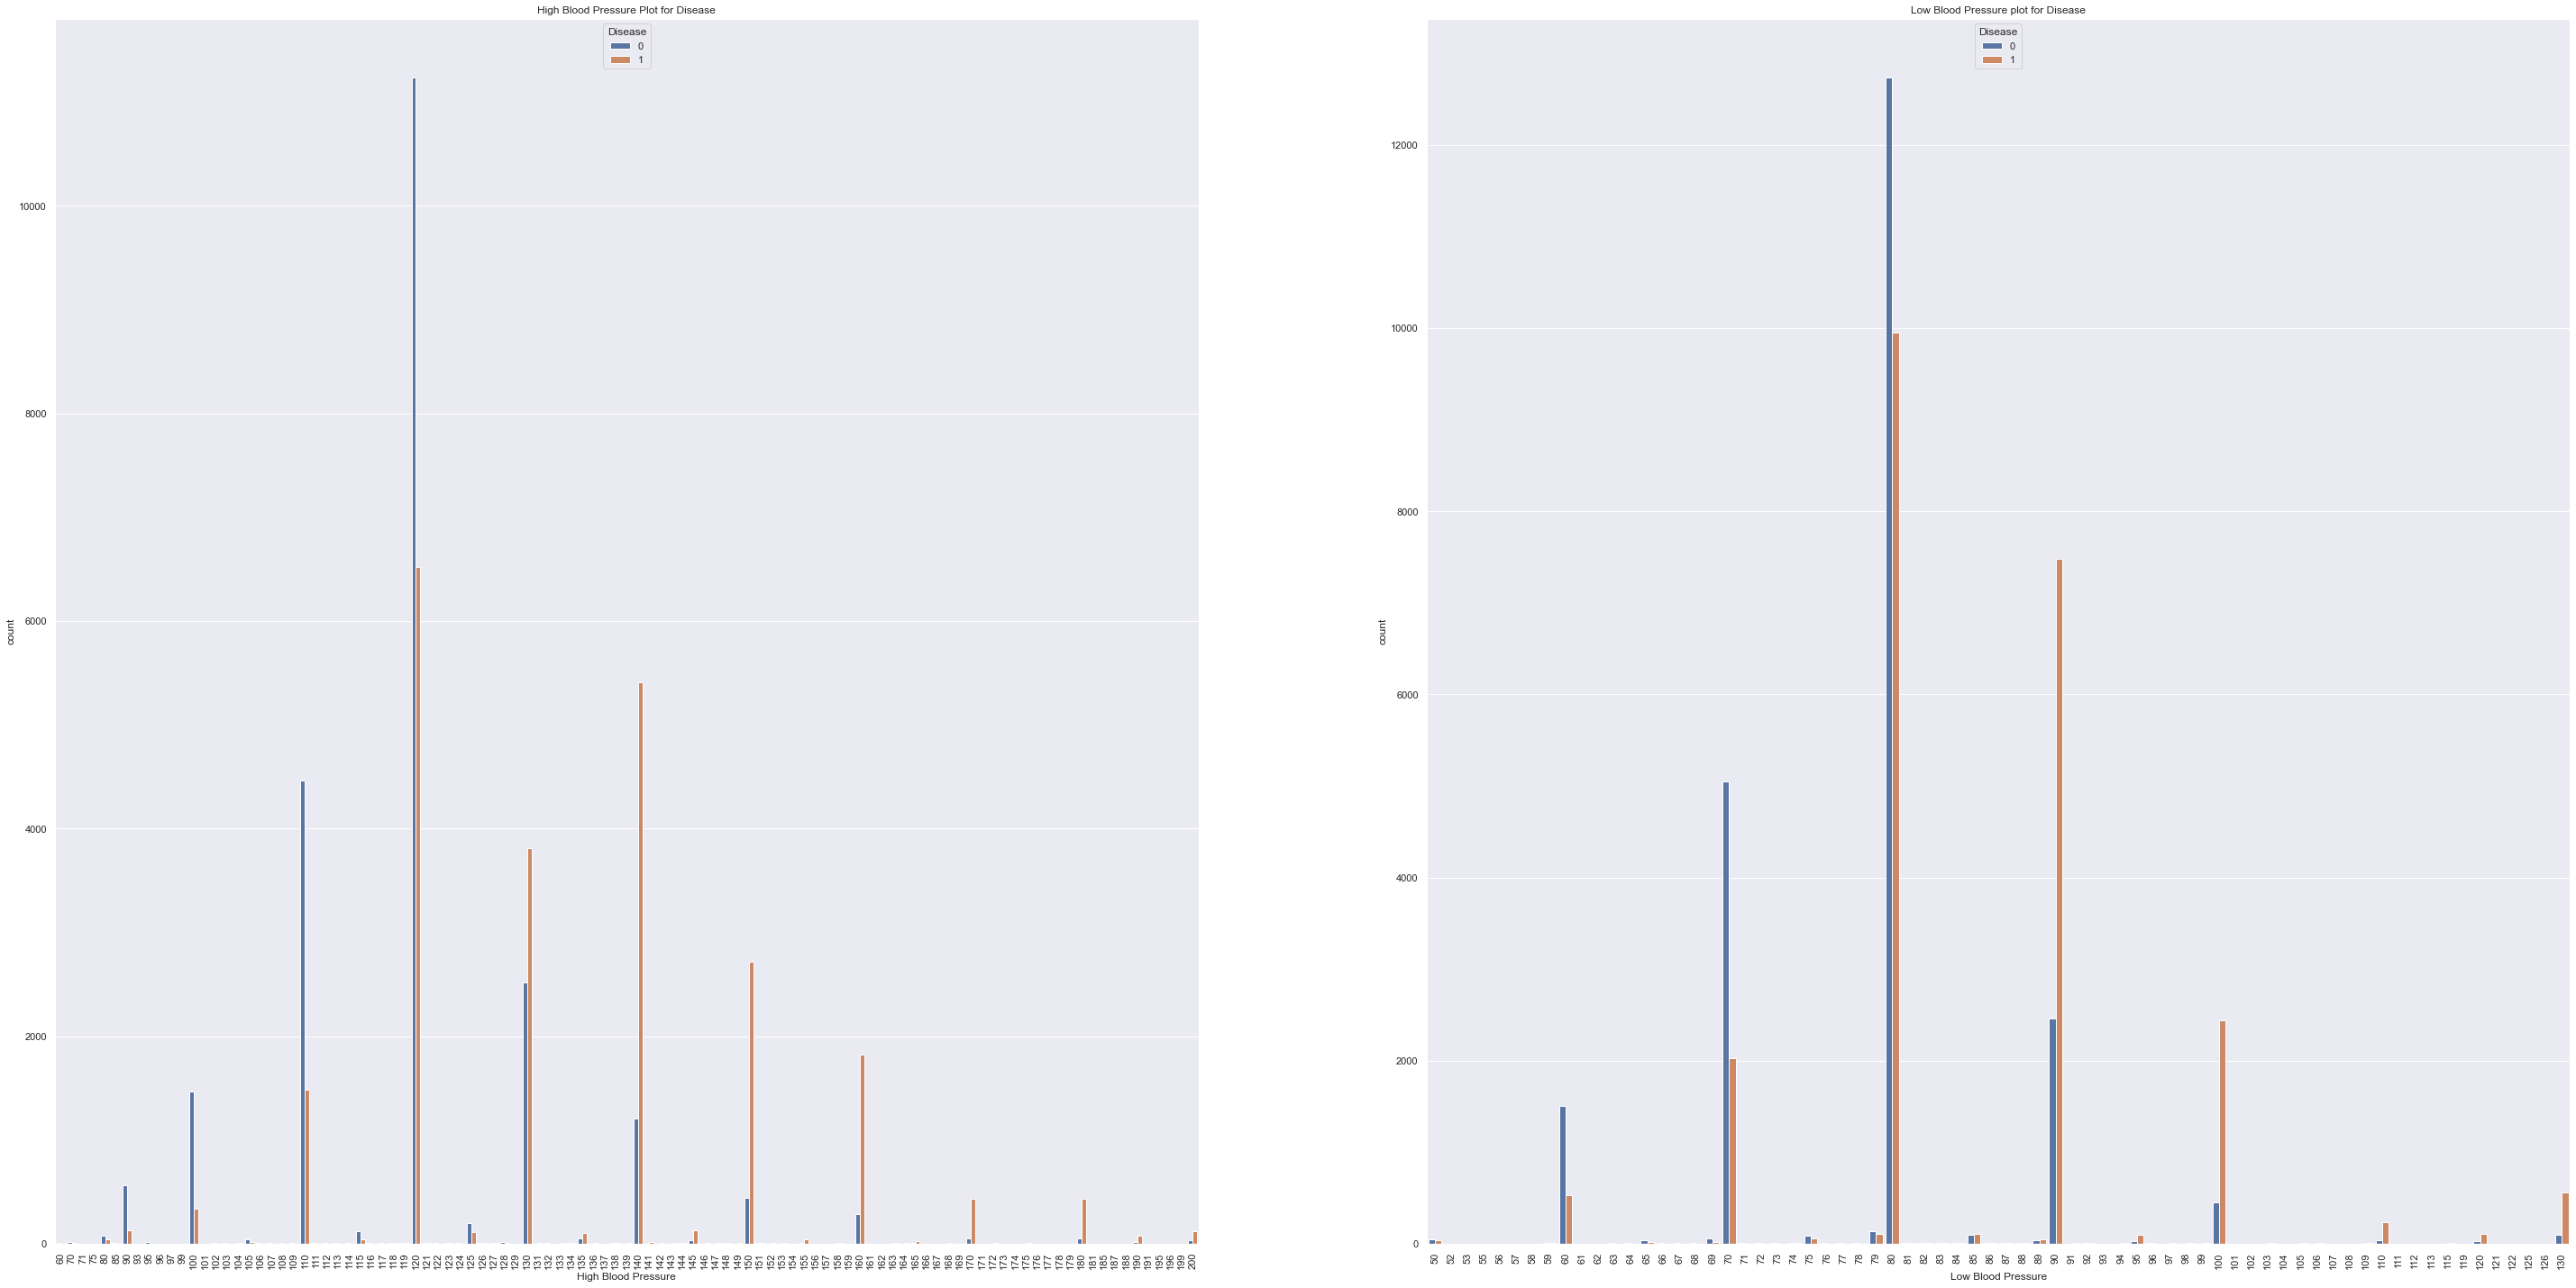

In [46]:
plt.figure(figsize=(50,25))
sns.set(font_scale = 1)
plt.subplot(1,2,1)
sns.countplot(x='High Blood Pressure',hue='Disease',data=df)
plt.xticks(rotation=90)
plt.title('High Blood Pressure Plot for Disease')
plt.subplot(1,2,2)
sns.countplot(x='Low Blood Pressure',hue='Disease',data=df)
plt.xticks(rotation=90)
plt.title('Low Blood Pressure plot for Disease')

**High Blood Pressure normal values range from 90 to 120 where the disease not been there chances are very high. We can see that if the High Blood Pressure is greater than 120 the risk of disease increases to a very high degree.** <br>
**Low Blood Pressure normal values range from 60 to 80 where the no disease chances are highest. Also, when this values go below these range of values the chances of having the disease increases drastically as this the lower bounds.**<br>

### Tri Variate Analysis

Text(0.5, 1.0, 'Cholesterol and Glucose levels for Disease')

<Figure size 1440x720 with 0 Axes>

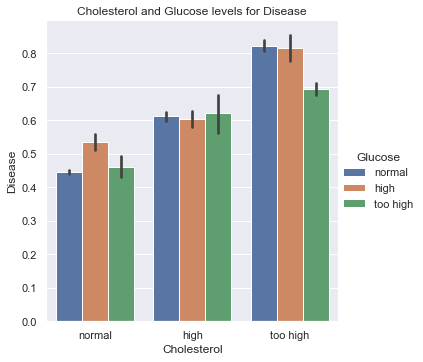

In [204]:
plt.figure(figsize=(20,10))
sns.catplot(x='Cholesterol',y='Disease',hue='Glucose',data=df,kind='bar')
plt.title('Cholesterol and Glucose levels for Disease')

**From the graph, it is evident that when the glucose and cholesterol levels are high/too high the risk of getting disease is higher than when it is at normal levels. When the levels of Cholesterol and Glucose are high/too high, the number of disease patients are always more than no disease whereas for normal no disease people are greater. So, people with high/too high cholesterol and glucose levels are the most vulnerable to disease and should take better care.** <br>

<Figure size 4320x1080 with 0 Axes>

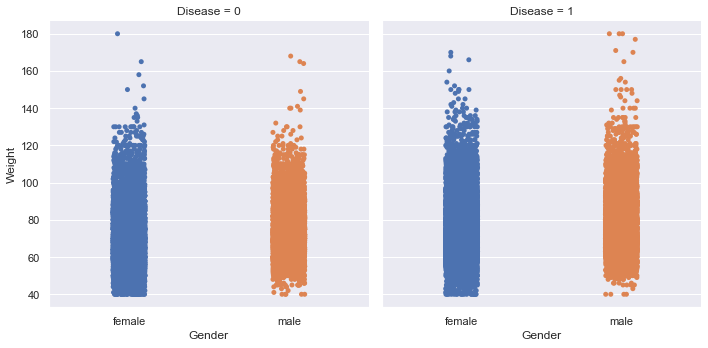

In [47]:
plt.figure(figsize=(60,15))
sns.catplot(x='Gender',y='Weight',col='Disease',data=df)

**Taking Weight and Gender into consideration we can see that when the weight increases beyond 120 kg the chances of contracting the disease become higher. People who are overweight or obese are always at more risk of getting diseases than those who are healthy.** <br>
**Gender disease distribution based on the weight is not very different for male or female. Both males and females seem to have the same vulnerability of getting the disease considering weight as an additional feature.** <br>

### Multi Variate Analysis 

<Figure size 1440x1080 with 0 Axes>

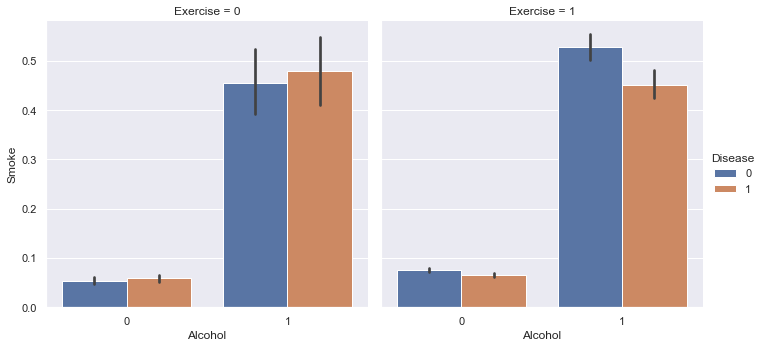

In [48]:
plt.figure(figsize=(20,15))
sns.catplot(hue = 'Disease', x = 'Alcohol', y='Smoke', kind="bar", col='Exercise', data =df)

**By comparing disease chances for poeple who consume alcohol, smoke and those who exercise or not, it can be seen that people who drink alcohol and smoke but do exercise always have higher chances of not having disease than who do not do exercise. Those people who don't do exercise, drik alcohol and smoke getting disease chance is always higher than not getting disease.** <br>
**For the people who do not consume alcohol and smoke, exercising makes them immune to disease as can be seen from the graph. So, exercising is best to remain healthy and not get disease.** <br>

# Data Pre-processing for Modeling

### One Hot Encoding Categorical Attributes and Scaling the Numerical Attributes 

**Glucose, Cholesterol and Gender Categorical columns cannot be handles by the algorithms so we need to convert these categorical columns to numerical columns for feeding them as input to the Machine Learning Models. To convert categorical columns to numerical columns, One hot Encoding or Dummies is done.** <br>
**For N categories we can represent the column using N-1 values for one hot encoding. The dropped value is considered to be default. For example, in Gender if we have 1 dummy column gender_male = 0 implies that the gender is female whereas gender_male=1 indicates male so instead of N columns we would have N-1 columns.** <br>

In [49]:
# Function to do one hot encoding by creating N-1 dummies and dropping the original column

def dummies(df,col): 
    return pd.get_dummies(df[col],prefix=col,drop_first=True).join(df).drop([col],axis=1)

In [50]:
# Dummy creation for Gender Feature for Train Data

df_onehot = dummies(df,'Gender')

In [51]:
# Dummy creation for Cholesterol Feature for Train Data

df_onehot = dummies(df_onehot,'Cholesterol')

In [52]:
# Dummy creation for Glucose Feature for Train Data

df_onehot = dummies(df_onehot,'Glucose')

In [53]:
df_onehot.head()

,Glucose_normal,Glucose_too high,Cholesterol_normal,Cholesterol_too high,Gender_male,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,Disease,BMI
0,1,0,1,0,0,59,167,88.0,130,68,0,0,1,0,31.553659
1,1,0,1,0,0,64,150,71.0,140,100,0,0,0,1,31.555556
2,1,0,1,0,0,41,166,83.0,100,70,0,1,1,0,30.120482
3,1,0,1,0,1,50,172,110.0,130,80,1,0,1,0,37.182261
4,0,0,0,0,0,39,162,61.0,110,80,0,0,1,0,23.243408


In [54]:
df_onehot.columns.values

array(['Glucose_normal', 'Glucose_too high', 'Cholesterol_normal',
       'Cholesterol_too high', 'Gender_male', 'Age', 'Height', 'Weight',
       'High Blood Pressure', 'Low Blood Pressure', 'Smoke', 'Alcohol',
       'Exercise', 'Disease', 'BMI'], dtype=object)

In [55]:
cols = ['Glucose_normal', 'Glucose_too high', 'Cholesterol_normal',
       'Cholesterol_too high', 'Gender_male', 'Age', 'Height', 'Weight',
       'High Blood Pressure', 'Low Blood Pressure', 'Smoke', 'Alcohol',
       'Exercise', 'BMI','Disease']

In [56]:
# Reversing the BMI and Disease column positions in train data

df_onehot = df_onehot[cols]

In [57]:
df_onehot.shape

(47229, 15)

**Normalizing/Scaling the Data for the KNN and SVM as distances are calculated so we want to make all the attributes on the same scale for the algorithm to be not biased to one input feature or the other**

In [58]:
# MinMax Scaling for the Train Data to make all the input features on same scale

min_max_scaler = preprocessing.MinMaxScaler()
train_scaled = min_max_scaler.fit_transform(df_onehot)

In [59]:
# Creating the Normalized Train Data

df_normalized = pd.DataFrame(train_scaled, columns=df_onehot.columns, index=df_onehot.index)
df_normalized.head()

,Glucose_normal,Glucose_too high,Cholesterol_normal,Cholesterol_too high,Gender_male,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,BMI,Disease
0,1.0,0.0,1.0,0.0,0.0,0.857143,0.560000,0.342857,0.500000,0.225,0.0,0.0,1.0,0.403611,0.0
1,1.0,0.0,1.0,0.0,0.0,1.000000,0.333333,0.221429,0.571429,0.625,0.0,0.0,0.0,0.403651,1.0
2,1.0,0.0,1.0,0.0,0.0,0.342857,0.546667,0.307143,0.285714,0.250,0.0,1.0,1.0,0.373052,0.0
3,1.0,0.0,1.0,0.0,1.0,0.600000,0.626667,0.500000,0.500000,0.375,1.0,0.0,1.0,0.523626,0.0
4,0.0,0.0,0.0,0.0,0.0,0.285714,0.493333,0.150000,0.357143,0.375,0.0,0.0,1.0,0.226417,0.0


### Dummies Creation and Normalizing Test Data

In [60]:
# Dummy creation for Gender Feature for Test Data

df_onehot_test = dummies(df_test,'Gender')

In [61]:
# Dummy creation for Cholesterol Feature for Test Data

df_onehot_test = dummies(df_onehot_test,'Cholesterol')

In [62]:
# Dummy creation for Glucose Feature for Test Data

df_onehot_test = dummies(df_onehot_test,'Glucose')

In [63]:
df_onehot_test.shape

(21000, 15)

In [64]:
# MinMax Scaling for the Test Data to make all the input features on same scale

min_max_scaler = preprocessing.MinMaxScaler()
test_scaled = min_max_scaler.fit_transform(df_onehot_test)

In [65]:
# Creating the Normalized Test Data

df_normalized_test = pd.DataFrame(test_scaled, columns=df_onehot_test.columns, index=df_onehot_test.index)
df_normalized_test.head()

,Glucose_normal,Glucose_too high,Cholesterol_normal,Cholesterol_too high,Gender_male,ID,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,BMI
0,1.0,0.0,0.0,0.0,0.0,0.000000,0.428571,0.466667,0.135714,0.285714,0.375,0.0,0.0,1.0,0.094882
1,1.0,0.0,1.0,0.0,0.0,0.000048,0.342857,0.586667,0.242857,0.428571,0.250,0.0,0.0,1.0,0.123394
2,0.0,0.0,1.0,0.0,1.0,0.000095,0.971429,0.573333,0.314286,0.428571,0.375,0.0,0.0,1.0,0.161765
3,1.0,0.0,1.0,0.0,0.0,0.000143,0.742857,0.440000,0.485714,0.714286,0.625,0.0,0.0,0.0,0.296232
4,1.0,0.0,1.0,0.0,0.0,0.000190,0.742857,0.560000,0.192857,0.428571,0.375,0.0,0.0,1.0,0.104612


In [66]:
df_normalized_test['ID'] = df_test['ID']

In [67]:
df_normalized_test.head()

,Glucose_normal,Glucose_too high,Cholesterol_normal,Cholesterol_too high,Gender_male,ID,Age,Height,Weight,High Blood Pressure,Low Blood Pressure,Smoke,Alcohol,Exercise,BMI
0,1.0,0.0,0.0,0.0,0.0,0,0.428571,0.466667,0.135714,0.285714,0.375,0.0,0.0,1.0,0.094882
1,1.0,0.0,1.0,0.0,0.0,1,0.342857,0.586667,0.242857,0.428571,0.250,0.0,0.0,1.0,0.123394
2,0.0,0.0,1.0,0.0,1.0,2,0.971429,0.573333,0.314286,0.428571,0.375,0.0,0.0,1.0,0.161765
3,1.0,0.0,1.0,0.0,0.0,3,0.742857,0.440000,0.485714,0.714286,0.625,0.0,0.0,0.0,0.296232
4,1.0,0.0,1.0,0.0,0.0,4,0.742857,0.560000,0.192857,0.428571,0.375,0.0,0.0,1.0,0.104612


# **Model Building**

**Metric Used: I am using Accuracy and Recall as the metric to tune and predict the disease. It is important to reduce the number of False Negatives which is percent of times Disease is true and our model predicts it correctly. Even though the person doesn't have disease but we do not want to predict no disease when the person has disease. It is better to predict a person having disease rather than no disease which may lead to later more complications. Accuracy is used to tune the model as we have a balanced dataset and it gives better stable results on test data as the models tuned using accuracy give better recall results** <br>

**Cross Validation is used to build generalized models using 5 fold CV. Data is split in 70:30 ratio for train and test data.** <br>

**GridSearchCV is used for tunning the hyper parameters from a range of values for each of the parameter in the tune grid. This is a brute force method where all the combinations are tried one after the other and sometimes it takes very long for tunning the hyper parameters to get the best tuned model.**

**Steps for Model Building for all the models:** <br>

**1. Building a Base Model on 70% split train data** <br>
**2. Tunning the Base Model Hyper parameters using GridSearchCV to build the best model** <br>
**3. Calculating the Accuracy and Recall score for the best model from the grid search on the validation dataset along with recording the best tuned hyper parameters values** <br>
**4. Calculate the AUC Score and Plot the ROC Curve and check the accuracy along with recall scores to see how well the model is performing.**<br>

# Naive Bayes

**Naive Bayes is a probabilistic algorithm which makes a naive assumption that all the input features are independent of each other and there is no relation among these features. It takes into account the prior probability of the class to calculate the posterior probability which is a multiplication prior and likelihood which is the conditional probability.**

**Naive Bayes has 3 different flavors Gaussian, Multinomial and Bernoulli NB.**

### Gaussian NB

In [68]:
X = df_onehot.drop(['Disease'],axis=1)
y = df_onehot['Disease']

In [69]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=16)

In [70]:
gnb = GaussianNB()


In [71]:
gnb.fit(X_train, y_train)

GaussianNB()

In [72]:
gnb_prediction = gnb.predict(X_test)

In [73]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, gnb_prediction)*100, 2)}%")

Accuracy: 68.41%


In [74]:
print(f"Recall: {round(metrics.recall_score(y_test, gnb_prediction)*100, 2)}%")

Recall: 56.31%


In [75]:
print(confusion_matrix(y_test,gnb_prediction))
print(classification_report(y_test,gnb_prediction))

[[5642 1333]
 [3143 4051]]
              precision    recall  f1-score   support

           0       0.64      0.81      0.72      6975
           1       0.75      0.56      0.64      7194

    accuracy                           0.68     14169
   macro avg       0.70      0.69      0.68     14169
weighted avg       0.70      0.68      0.68     14169



### Gaussian NB Hyper Tunning

**The Hyper parameter to be tuned for Gaussian Naive Bayes is var_smoothing used the GridSearchCV.** <br>
**var_smoothing: This parameter is a smoothing parameter which is the Portion of the largest variance of all features to variance for calculation stability as per the documentation.**

In [76]:
param_grid = {'var_smoothing':[1e-09,.0002,.01,.1,.6]}

In [77]:
gnb_grid = GridSearchCV(gnb, param_grid, cv=5,scoring='accuracy',verbose=1)

In [78]:
gnb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 0.0002, 0.01, 0.1, 0.6]},
             scoring='accuracy', verbose=1)

In [79]:
gnb_grid_pred = gnb_grid.predict(X_test)

In [80]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, gnb_grid_pred)*100, 2)}%")

Accuracy: 70.29%


In [81]:
print(confusion_matrix(y_test,gnb_grid_pred))
print(classification_report(y_test,gnb_grid_pred))

[[5687 1288]
 [2921 4273]]
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      6975
           1       0.77      0.59      0.67      7194

    accuracy                           0.70     14169
   macro avg       0.71      0.70      0.70     14169
weighted avg       0.72      0.70      0.70     14169



In [82]:
gnb_grid.best_params_

{'var_smoothing': 0.1}

In [83]:
def roc_auc(model,model_name):
    # Plotting the ROC Curve

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('{}: ROC AUC=%.3f'.format(model_name) % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + model_name)
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

No Skill: ROC AUC=0.500
Gaussian Grid NB: ROC AUC=0.771


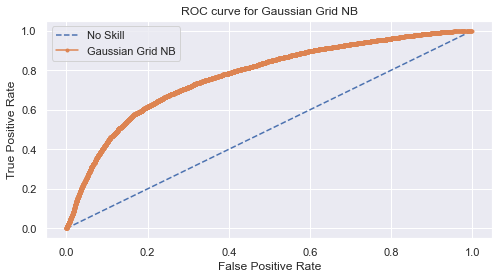

In [84]:
roc_auc(gnb_grid,"Gaussian Grid NB")

### Multinomial NB

**Multinomial NB is suitable for discrete features as it is based on occurence counting.**

In [85]:
mnb = MultinomialNB()

In [86]:
mnb.fit(X_train, y_train)

MultinomialNB()

In [87]:
mnb_pred = mnb.predict(X_test)

In [88]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, mnb_pred)*100, 2)}%")

Accuracy: 70.86%


In [89]:
print(confusion_matrix(y_test,mnb_pred))
print(classification_report(y_test,mnb_pred))

[[5347 1628]
 [2501 4693]]
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      6975
           1       0.74      0.65      0.69      7194

    accuracy                           0.71     14169
   macro avg       0.71      0.71      0.71     14169
weighted avg       0.71      0.71      0.71     14169



### Multinomial NB Hyper Tunning



**Hyper Parameters for MNB:** <br>
**1. Alpha: It is a smoothing parameter(0 for no smoothing)** <br>
**2. fit_prior: It is parameter to learn the prior probabilities of the class. If false, no prior class distribution is taken into account rather a uniform prior distribution is used.** <br>

In [90]:
param_grid = {'alpha': [1, 0.1, 0.01, 2, 3, 4, 5, 6, 7, 8, 9, 0.001, 0.0001],'fit_prior':['True','False']}

In [91]:
mnb_grid = GridSearchCV(mnb, param_grid, cv=5,scoring='accuracy',verbose=1)

In [92]:
mnb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    2.4s finished


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 2, 3, 4, 5, 6, 7, 8, 9, 0.001,
                                   0.0001],
                         'fit_prior': ['True', 'False']},
             scoring='accuracy', verbose=1)

In [93]:
mnb_grid_pred = mnb_grid.predict(X_test)

In [94]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, mnb_grid_pred)*100, 2)}%")

Accuracy: 70.86%


In [95]:
print(confusion_matrix(y_test,mnb_grid_pred))
print(classification_report(y_test,mnb_grid_pred))

[[5347 1628]
 [2501 4693]]
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      6975
           1       0.74      0.65      0.69      7194

    accuracy                           0.71     14169
   macro avg       0.71      0.71      0.71     14169
weighted avg       0.71      0.71      0.71     14169



In [96]:
mnb_grid.best_params_

{'alpha': 0.1, 'fit_prior': 'True'}

No Skill: ROC AUC=0.500
Multinomial Grid NB: ROC AUC=0.758


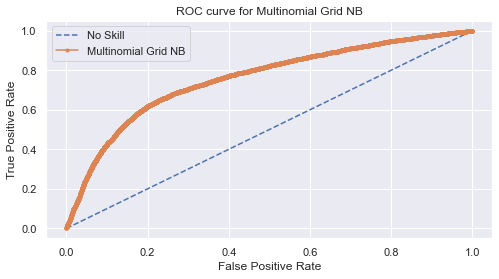

In [97]:
roc_auc(mnb_grid,"Multinomial Grid NB")

### Bernoulli NB

**Bernoulli NB is used for binary/features which only takes into account if the feature occurs or not 0 or 1. This is the worst performing model so I have not tuned the hyper parameters for this model.**

In [98]:
bnb = BernoulliNB()

In [99]:
bnb.fit(X_train,y_train)

BernoulliNB()

In [100]:
bnb_pred = bnb.predict(X_test)

In [101]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, bnb_pred)*100, 2)}%")

Accuracy: 58.72%


In [102]:
print(confusion_matrix(y_test,bnb_pred))
print(classification_report(y_test,bnb_pred))

[[5484 1491]
 [4358 2836]]
              precision    recall  f1-score   support

           0       0.56      0.79      0.65      6975
           1       0.66      0.39      0.49      7194

    accuracy                           0.59     14169
   macro avg       0.61      0.59      0.57     14169
weighted avg       0.61      0.59      0.57     14169



No Skill: ROC AUC=0.500
Bernoulli NB: ROC AUC=0.609


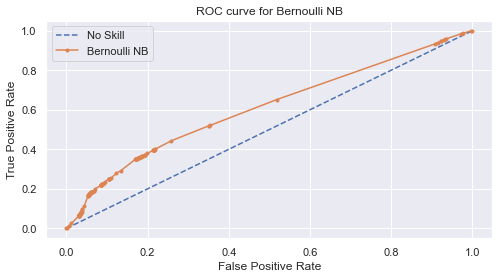

In [103]:
roc_auc(bnb,"Bernoulli NB")

**Among the Gaussian, Multinomial and Bernoulli NB, the best model is Multinomial NB which gives the best accuracy of 71% and Recall of 65%.** 

In [104]:
mnb_tuned_pred = mnb_grid.predict(df_onehot_test[df_onehot_test.columns[df_onehot_test.columns!="ID"]])

# Random Forest

**Random Forest is an Ensemble Tree based Machine Learning Algorithm used for binary classification. Random Forest uses multiple Decision Trees in parallel with input data feed using sampling with replacement, a technique called Bagging and using Majority Vote for Classification to make the final decision about the membership of the data point belonging to 1 class. For Regression, using the Averaging to make the final prediction.**

In [105]:
X = df_onehot.drop(['Disease'],axis=1)
y = df_onehot['Disease']

In [106]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=16)

In [107]:
rf = RandomForestClassifier(random_state=16)

In [108]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=16)

In [109]:
rf_pred = rf.predict(X_test)

In [110]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, rf_pred)*100, 2)}%")

Accuracy: 70.36%


In [111]:
print(confusion_matrix(y_test,rf_pred))
print(classification_report(y_test,rf_pred))

[[4862 2113]
 [2086 5108]]
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      6975
           1       0.71      0.71      0.71      7194

    accuracy                           0.70     14169
   macro avg       0.70      0.70      0.70     14169
weighted avg       0.70      0.70      0.70     14169



### Random Forest Hyper Tunning

**Random Forest Hyper Parameters:** <br>
    
**1. max_depth: The maximum depth of the tree. The more deeper are the trees, the more number of splits it takes capturing more information about the data which also increases chances of overfitting.** <br>
**2. max_features: The maximum number of features to be considered for making the best split. For RF, square root number of the features are taken into account at each split randomly to avoid the high correlation between the input features.** <br>
**3. min_samples_leaf: Minimum number of samples required at the leaf node.** <br>
**4. min_samples_split: Minimum number of samples to be considered for splitting a node. This number of instances must be met before splitting the internal node at each of the node. This is the minimum number of samples required on both the left and right branches for the node to be considered as the leaf node after the split.** <br>
**5. n_estimators: The number of trees in the forest. The more the number of trees in the forest, the better and robust generalized model is built as it becomes easy to predict the classes. But having too many number of trees would increase the complexity and time taken to train the model. So, optimum number of trees have to be selected.** <br>

In [112]:
param_grid_rf={'max_depth': [25,10, 50, 100],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [10,30,50],
            'min_samples_split': [500,800,1000],
            'n_estimators': [300,500, 1000,2000]}

In [113]:
rf_grid = GridSearchCV(rf, param_grid_rf, scoring='accuracy',cv = 5,verbose=1,n_jobs=-1)

In [114]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 80.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 92.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=16), n_jobs=-1,
             param_grid={'max_depth': [25, 10, 50, 100],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [10, 30, 50],
                         'min_samples_split': [500, 800, 1000],
                         'n_estimators': [300, 500, 1000, 2000]},
             scoring='accuracy', verbose=1)

In [115]:
rf_grid_pred = rf_grid.predict(X_test)

In [116]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, rf_grid_pred)*100, 2)}%")

Accuracy: 72.86%


In [117]:
rf_grid.best_params_

{'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 50,
 'min_samples_split': 500,
 'n_estimators': 1000}

In [118]:
rf_grid.best_score_

0.7342407743496673

In [119]:
print(confusion_matrix(y_test,rf_grid_pred))
print(classification_report(y_test,rf_grid_pred))

[[5207 1768]
 [2078 5116]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      6975
           1       0.74      0.71      0.73      7194

    accuracy                           0.73     14169
   macro avg       0.73      0.73      0.73     14169
weighted avg       0.73      0.73      0.73     14169



In [120]:
rf_grid_fea_imp = pd.DataFrame({'Features':X_train.columns,'Feature_Importance':rf_grid.best_estimator_.feature_importances_})

In [121]:
rf_grid_fea_imp = rf_grid_fea_imp.sort_values(by='Feature_Importance',ascending=False)

In [122]:
rf_grid_fea_imp

,Features,Feature_Importance
8,High Blood Pressure,0.479653
9,Low Blood Pressure,0.213197
5,Age,0.117378
2,Cholesterol_normal,0.051559
3,Cholesterol_too high,0.050713
13,BMI,0.036751
7,Weight,0.028996
6,Height,0.006071
0,Glucose_normal,0.003847
12,Exercise,0.003666


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

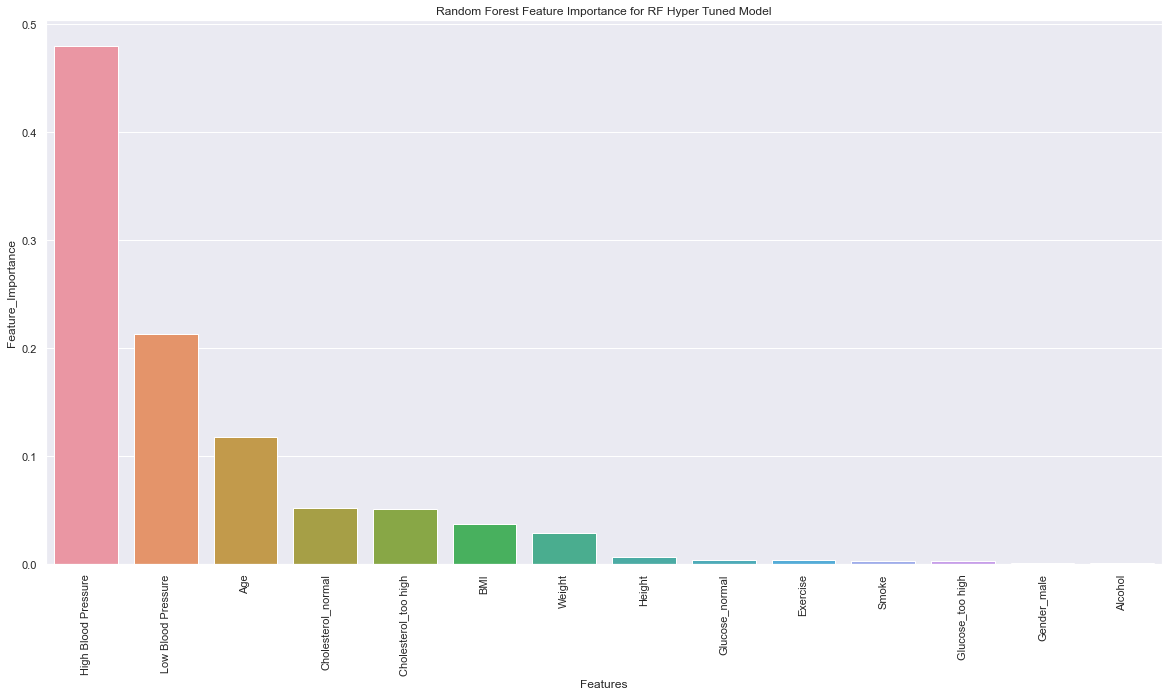

In [123]:
plt.figure(figsize=(20,10))
sns.barplot(x=rf_grid_fea_imp.Features,y=rf_grid_fea_imp["Feature_Importance"])
plt.ylabel('Feature_Importance')
plt.title('Random Forest Feature Importance for RF Hyper Tuned Model')
plt.xticks(rotation=90)

**We can see from the feature importance that High Blood Pressure, Low Blood Pressure, Age, Cholesterol_normal, Cholesterol_high, BMI are the most important features among all the input features. These are the most important features in helping the model to predict the disease accurately.**

No Skill: ROC AUC=0.500
RF Grid: ROC AUC=0.796


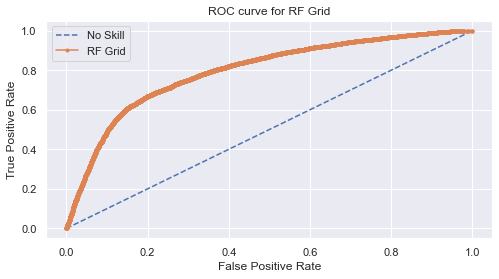

In [124]:
roc_auc(rf_grid,"RF Grid")

**The best hyper tuned Random Forest Model has an accuracy of 73% and recall of 71%.**

In [125]:
rf_tuned_pred = rf_grid.predict(df_onehot_test[df_onehot_test.columns[df_onehot_test.columns!="ID"]])

# Gradient Boosting 

**Gradient Boosting is also an Ensemble Tree based Machine Learning Algorithm. This algorithm uses Boosting technique with trees planted in series and not in parallel as it is in case of Random Forest. The trees work on residuals which is the error propogated from 1 tree to another tree to work on this tough tasks being misclassified earlier in order to reduce the error in the subsequent trees. Residuals are passed onto the next tree to see which instances are misclassified and make it good later on by giving these instances more importance for improving the mistakes made earlier.**

In [126]:
X = df_onehot.drop(['Disease'],axis=1)
y = df_onehot['Disease']

In [127]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=16)

In [128]:
gbm=GradientBoostingClassifier(random_state=16)

In [129]:
gbm.fit(X_train,y_train)

GradientBoostingClassifier(random_state=16)

In [130]:
gbm_pred = gbm.predict(X_test)

In [131]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, gbm_pred)*100, 2)}%")

Accuracy: 73.24%


In [132]:
print(confusion_matrix(y_test,gbm_pred))
print(classification_report(y_test,gbm_pred))

[[5255 1720]
 [2072 5122]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6975
           1       0.75      0.71      0.73      7194

    accuracy                           0.73     14169
   macro avg       0.73      0.73      0.73     14169
weighted avg       0.73      0.73      0.73     14169



### Gradient Boosting Hyper Tunning

**Gradient Boosting Hyper Parameters:** <br>

**1. n_estimators: The number of trees in the forest. The more the number of trees in the forest, the better and robust generalized model is built as it becomes easy to predict the classes. But having too many number of trees would increase the complexity, time taken to train the model and increase chances of overfitting.** <br>
**2. max_depth: The maximum depth of the tree. The more deeper are the trees, the more number of splits it takes capturing more information about the data which also increases chances of overfitting.** <br>
**3. subsample: The fraction of samples to be used for fitting the individual base learners.** <br>
**4. learning_rate: This value used to shrink the contribution of each tree.** <br>

In [133]:
param_grid_gbm={'n_estimators': [100,300,500],
                'max_depth': [2,5,10],
                'subsample':[0.6,0.7,0.8,0.9],
                'learning_rate': [0.05,0.1,0.2]}

In [134]:
gbm_grid = GridSearchCV(gbm, param_grid_gbm, scoring='accuracy',cv = 5,verbose=1,n_jobs=-1)

In [135]:
gbm_grid.fit(X_train,y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 40.8min finished


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=16),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [2, 5, 10],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [136]:
gbm_grid_pred = gbm_grid.predict(X_test)

In [137]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, gbm_grid_pred)*100, 2)}%")

Accuracy: 73.2%


In [138]:
gbm_grid.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}

In [139]:
gbm_grid.best_score_

0.7360254083484573

In [140]:
print(confusion_matrix(y_test,gbm_grid_pred))
print(classification_report(y_test,gbm_grid_pred))

[[5221 1754]
 [2043 5151]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6975
           1       0.75      0.72      0.73      7194

    accuracy                           0.73     14169
   macro avg       0.73      0.73      0.73     14169
weighted avg       0.73      0.73      0.73     14169



In [141]:
gbm_grid_fea_imp = pd.DataFrame({'Features':X_train.columns,'Feature_Importance':gbm_grid.best_estimator_.feature_importances_})

In [142]:
gbm_grid_fea_imp = gbm_grid_fea_imp.sort_values(by='Feature_Importance',ascending=False)

In [143]:
gbm_grid_fea_imp

,Features,Feature_Importance
8,High Blood Pressure,0.727520
5,Age,0.120105
3,Cholesterol_too high,0.049542
13,BMI,0.026574
2,Cholesterol_normal,0.023360
9,Low Blood Pressure,0.021008
7,Weight,0.013377
6,Height,0.005019
12,Exercise,0.004238
10,Smoke,0.002875


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

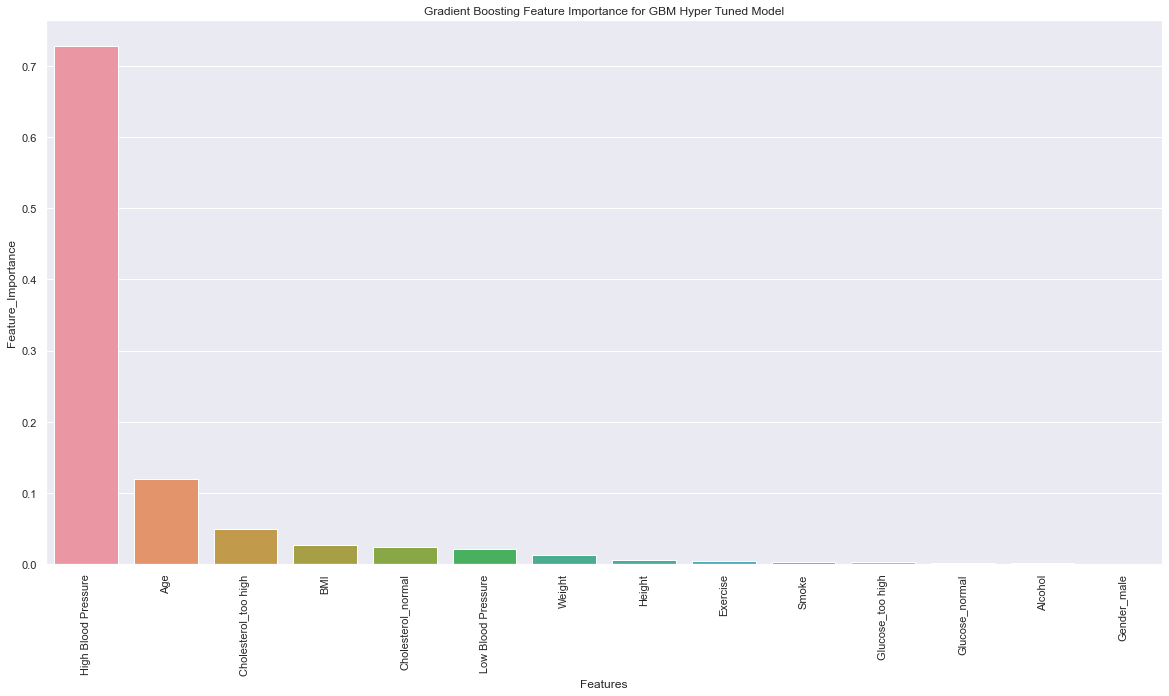

In [144]:
plt.figure(figsize=(20,10))
sns.barplot(x=gbm_grid_fea_imp.Features,y=gbm_grid_fea_imp["Feature_Importance"])
plt.ylabel('Feature_Importance')
plt.title('Gradient Boosting Feature Importance for GBM Hyper Tuned Model')
plt.xticks(rotation=90)

**Input features High Blood Pressure, Age, Cholesterol_too_high, BMI, cholesterol_normal, Low Blood Pressure are the most important features among all the input features. These are the most important features in helping the model to predict the disease accurately. These features make most of the contribution in the model prediction with High Blood Pressure making the biggest contribution.**

No Skill: ROC AUC=0.500
GBM Grid: ROC AUC=0.797


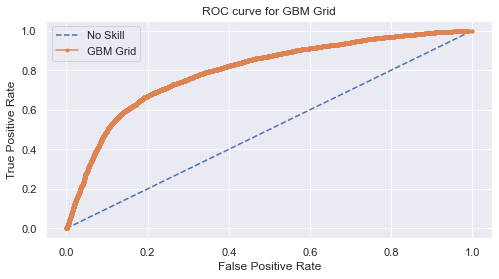

In [145]:
roc_auc(gbm_grid,"GBM Grid")

**The Hyper tuned Grid GBM model is the best model with a accuracy of 73%, recall of 72% and AUC score of 0.797 which is almost equal to 0.8.**

In [146]:
gbm_tuned_pred = gbm_grid.predict(df_onehot_test[df_onehot_test.columns[df_onehot_test.columns!="ID"]])

# KNN 

**KNN is a distance based supervised learning algorithm to classify similar things together based on the K nearest neighbors.**

In [147]:
X = df_normalized.drop(['Disease'],axis=1)
y = df_normalized['Disease']

In [148]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=16)

In [149]:
knn = KNeighborsClassifier()

In [150]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [151]:
knn_pred = knn.predict(X_test)

In [152]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, knn_pred)*100, 2)}%")

Accuracy: 69.21%


In [153]:
print(confusion_matrix(y_test,knn_pred))
print(classification_report(y_test,knn_pred))

[[4811 2164]
 [2198 4996]]
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      6975
         1.0       0.70      0.69      0.70      7194

    accuracy                           0.69     14169
   macro avg       0.69      0.69      0.69     14169
weighted avg       0.69      0.69      0.69     14169



### KNN Hyper Tunning

**KNN Hyper parameters:** <br>

**1. algorithm: Algorithm used to compute nearest neighbors** <br>
**2. n_neighbors: Number of neighbors to be considered while classifying the points into different classes**<br>
**3. weights: Weights assigned to each neighbor. If set to uniform, all points near to this point are equally weighted while doing classification and if set to distance, closer neighbors are given more weightage than others and there is no equal weightage to all the data points.**<br>
**4. p: It defines the distance function to be used which is the power of Minkowski distance function. If 1, means Manhattan distance and if 2, means Euclidean Distance.**<br>

In [154]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [155]:
param_grid = {'algorithm':['ball_tree', 'kd_tree', 'brute'],
'n_neighbors': [1, 10, 25, 50, 75, 100, 200],
'weights':['uniform','distance'],
'p':[1,2]}

In [156]:
knn_grid = GridSearchCV(knn, param_grid, cv=5,scoring='accuracy',verbose=1, n_jobs=-1)

In [157]:
knn_grid.fit(X_train,y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 11.1min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 10, 25, 50, 75, 100, 200],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [158]:
knn_grid_pred = knn_grid.predict(X_test)

In [159]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, knn_grid_pred)*100, 2)}%")

Accuracy: 72.12%


In [160]:
print(confusion_matrix(y_test,knn_grid_pred))
print(classification_report(y_test,knn_grid_pred))

[[5229 1746]
 [2205 4989]]
              precision    recall  f1-score   support

         0.0       0.70      0.75      0.73      6975
         1.0       0.74      0.69      0.72      7194

    accuracy                           0.72     14169
   macro avg       0.72      0.72      0.72     14169
weighted avg       0.72      0.72      0.72     14169



In [161]:
knn_grid.best_params_

{'algorithm': 'brute', 'n_neighbors': 75, 'p': 1, 'weights': 'uniform'}

In [162]:
knn_grid.best_score_

0.7220508166969147

No Skill: ROC AUC=0.500
KNN Grid: ROC AUC=0.785


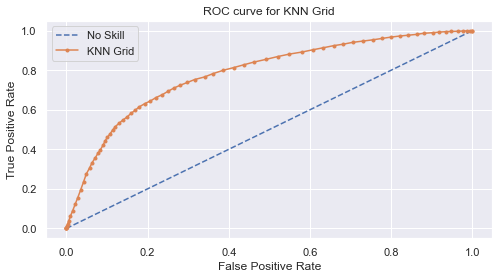

In [163]:
roc_auc(knn_grid,"KNN Grid")

**The best model for the KNN grid has Manhattan distance function used with 75 nearest neighbors to be considered while making the decision and the weightage given is equal to all the data points. This model gives an accuracy score of 72% with a recall of 69%.**

In [164]:
knn_tuned_pred = knn_grid.predict(df_normalized_test[df_normalized_test.columns[df_normalized_test.columns!="ID"]])

# SVM

**SVM is also distance based Supervised machine learning algorithm. The thing that makes SVM uniques is that only a very few data points take part in the decision boundary creation called as support vectors making it highly suitable for High Dimensional Data. Creating a hyperplane to seperate the classes. One more thing is that different kernels can be used to create linear as well as non-linear decision boundaries to seperate the classes making it useful for non-linear problems as well.**

### Linear SVM

In [165]:
X = df_normalized.drop(['Disease'],axis=1)
y = df_normalized['Disease']

In [166]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=16)

In [167]:
lin_clf = LinearSVC()

In [168]:
lin_clf.fit(X_train,y_train)

LinearSVC()

In [169]:
lin_clf_pred = lin_clf.predict(X_test)

In [170]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, lin_clf_pred)*100, 2)}%")

Accuracy: 72.48%


In [171]:
print(confusion_matrix(y_test,lin_clf_pred))
print(classification_report(y_test,lin_clf_pred))

[[5342 1633]
 [2266 4928]]
              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73      6975
         1.0       0.75      0.69      0.72      7194

    accuracy                           0.72     14169
   macro avg       0.73      0.73      0.72     14169
weighted avg       0.73      0.72      0.72     14169



### Linear SVC Hyper Tunning

**Linear SVC Hyper parameters:** <br>

**1. C: This is the cost parameter to allow how much of misclassification is permitted.** <br>
**2. loss: The loss function to be used. Squared Hinge Loss is used in this case.** <br>
**3. Penalty: L1 or L2 norm regularisation parameter to be used to penalise the points making it more robust and generalized model.** <br>
**4. dual: Select the algorithm to either solve the dual or primal optimization problem. Set to false when Number of instances are greater than number of features.** <br>
**5. max_iter: The number of iterations to run the algorithm.** <br>

In [172]:
param_grid = {'C':[0.01,0.1,0.2,0.4,0.5,0.6,0.75,0.8,1,1.5,5,10],'loss': ['squared_hinge'],
              'penalty': ['l1'],
              'dual': [False],
              'max_iter':[2000,2500,3500,4000,5000]}

In [173]:
lin_svm_grid = GridSearchCV(lin_clf, param_grid, cv=5,scoring='accuracy')

In [174]:
lin_svm_grid.fit(X_train,y_train)

C:\Users\hites\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hites\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hites\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hites\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\hites\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.75, 0.8, 1, 1.5,
                               5, 10],
                         'dual': [False], 'loss': ['squared_hinge'],
                         'max_iter': [2000, 2500, 3500, 4000, 5000],
                         'penalty': ['l1']},
             scoring='accuracy')

In [175]:
lin_svm_grid.best_params_

{'C': 0.2,
 'dual': False,
 'loss': 'squared_hinge',
 'max_iter': 2000,
 'penalty': 'l1'}

In [176]:
svm_grid_pred = lin_svm_grid.predict(X_test)

In [177]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, svm_grid_pred)*100, 2)}%")

Accuracy: 72.47%


In [178]:
print(confusion_matrix(y_test,svm_grid_pred))
print(classification_report(y_test,svm_grid_pred))

[[5347 1628]
 [2273 4921]]
              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73      6975
         1.0       0.75      0.68      0.72      7194

    accuracy                           0.72     14169
   macro avg       0.73      0.73      0.72     14169
weighted avg       0.73      0.72      0.72     14169



**The best tuned Linear SVC model gives an accuracy of 72% and Recall of 68%.** <br>
**For Linear SVC, there is no probability prediction available so we cannot plot the AUC ROC Curve.** <br>

In [179]:
svmlin_tuned_pred = lin_svm_grid.predict(df_normalized_test[df_normalized_test.columns[df_normalized_test.columns!="ID"]])

### Non Linear SVM (RBF Kernel)

**The most common non-linear Kernel used is RBF. Non-linear kernels are used when the decision boundary to seperate the classes is required as the classes can no longer be linearly seperated.** 

In [180]:
nlin_clf = SVC(kernel='rbf',random_state=42)

In [181]:
nlin_clf.fit(X_train,y_train)

SVC(random_state=42)

In [182]:
nlin_clf_pred = nlin_clf.predict(X_test)

In [183]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, nlin_clf_pred)*100, 2)}%")

Accuracy: 73.11%


In [184]:
print(confusion_matrix(y_test,nlin_clf_pred))
print(classification_report(y_test,nlin_clf_pred))

[[5372 1603]
 [2207 4987]]
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      6975
         1.0       0.76      0.69      0.72      7194

    accuracy                           0.73     14169
   macro avg       0.73      0.73      0.73     14169
weighted avg       0.73      0.73      0.73     14169



### RBF Kernel SVC Hyper Tunning

**Non Linear SVC RBF Kernel Hyper parameters:** <br>

**1. C: The cost parameter of the SVM used to make better classification.** <br> 
**2. Gamma: Used for Non-linear SVM. It is the kernel function used to cast the model to a higher dimension. A small gamma will give a model with low bias and high variance while a large gamma will give a model with higher bias and low variance.** <br>

In [185]:
nlin_clf_grid = SVC(kernel='rbf',random_state=42,probability=True)

In [189]:
param_grid = {'C':[0.01,0.2,0.5,0.8,10], 'gamma':[0.1,0.25,0.5,0.75,10]}


In [190]:
gridrbf = GridSearchCV(nlin_clf_grid, param_grid, cv=5, scoring='accuracy', verbose=1,n_jobs=-1)

In [191]:
gridrbf.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 138.7min finished


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.2, 0.5, 0.8, 10],
                         'gamma': [0.1, 0.25, 0.5, 0.75, 10]},
             scoring='accuracy', verbose=1)

In [192]:
gridrbf_pred = gridrbf.predict(X_test)

In [193]:
gridrbf.best_params_

{'C': 10, 'gamma': 0.5}

In [194]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, gridrbf_pred)*100, 2)}%")

Accuracy: 73.29%


In [195]:
print(confusion_matrix(y_test,gridrbf_pred))
print(classification_report(y_test,gridrbf_pred))

[[5393 1582]
 [2202 4992]]
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74      6975
         1.0       0.76      0.69      0.73      7194

    accuracy                           0.73     14169
   macro avg       0.73      0.73      0.73     14169
weighted avg       0.74      0.73      0.73     14169



No Skill: ROC AUC=0.500
RBF SVM Grid: ROC AUC=0.790


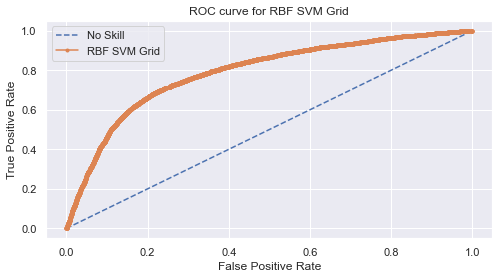

In [196]:
roc_auc(gridrbf,"RBF SVM Grid")

**The tuned non-linear RBF SVC model gives an accuracy of 73% with recall of 69%.**

In [197]:
gridrbf_tuned_pred = gridrbf.predict(df_normalized_test[df_normalized_test.columns[df_normalized_test.columns!="ID"]])

# Summary of Best Models for all 6 Algorithms after Tunning Hyperparameters

In [198]:
summary_df = pd.DataFrame({'Algorithms':['GNBC','MNBC','KNN','SVM-Linear','SVM-RBF','RF','GBM'],'Best_Recall_Score':[0.59,0.65,0.69,0.68,0.69,0.71,0.72],'Best_Accuracy_Score':[0.70,0.71,0.72,0.72,0.73,0.73,0.73],
                           'Best_AUC_Score':[0.771,0.758,0.785,"-",0.790,0.796,0.797],
                           'Hyperparameters_Best_Model':[[gnb_grid.best_params_],[mnb_grid.best_params_],[knn_grid.best_params_],[lin_svm_grid.best_params_],[gridrbf.best_params_],[rf_grid.best_params_],[gbm_grid.best_params_]]})

In [199]:
pd.set_option('display.max_colwidth', -1)

<ipython-input-199-0891b765a168>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [200]:
summary_df

,Algorithms,Best_Recall_Score,Best_Accuracy_Score,Best_AUC_Score,Hyperparameters_Best_Model
0,GNBC,0.59,0.70,0.771,[{'var_smoothing': 0.1}]
1,MNBC,0.65,0.71,0.758,"[{'alpha': 0.1, 'fit_prior': 'True'}]"
2,KNN,0.69,0.72,0.785,"[{'algorithm': 'brute', 'n_neighbors': 75, 'p': 1, 'weights': 'uniform'}]"
3,SVM-Linear,0.68,0.72,-,"[{'C': 0.2, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 2000, 'penalty': 'l1'}]"
4,SVM-RBF,0.69,0.73,0.79,"[{'C': 10, 'gamma': 0.5}]"
5,RF,0.71,0.73,0.796,"[{'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 500, 'n_estimators': 1000}]"
6,GBM,0.72,0.73,0.797,"[{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}]"


**GBM is the best model among all the models with best recall, accuracy and auc score. The auc score is almost 0.8 which means that it is able to distinguish between the False Positives and False Negatives very nicely 80% of the time. So, the algorithm is not randomly predicting if the person has disease rather it is making good predictions and not random.** <br>

**The performance is almost the same on training and testing data in the range of 70 to 73% for accuracy and good stable auc scores indicating it is a robust and generalized model with hardly any difference in performance on these 2 datasets.** 

# Final Prediction for the Test Data for all the 6 Algorithms

In [201]:
df_test_final = pd.DataFrame({'ID':df_normalized_test['ID'],' NBC':mnb_tuned_pred,'KNN':knn_tuned_pred,'SVM-Linear':svmlin_tuned_pred,'SVM-RBF':gridrbf_tuned_pred,'RF':rf_tuned_pred,'GBM':gbm_tuned_pred})

In [202]:
df_test_final

,ID,NBC,KNN,SVM-Linear,SVM-RBF,RF,GBM
0,0,0,0.0,0.0,0.0,0,0
1,1,0,0.0,0.0,0.0,0,0
2,2,0,0.0,1.0,0.0,1,1
3,3,1,1.0,1.0,1.0,1,1
4,4,0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...
20995,20995,0,1.0,0.0,0.0,1,0
20996,20996,0,0.0,0.0,0.0,0,0
20997,20997,1,0.0,0.0,0.0,1,0
20998,20998,1,1.0,1.0,1.0,1,1


In [203]:
df_test_final.to_csv('disease_test_pred_final.csv',index=False)